In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
# plotting options
plt.rc("figure", dpi=400)                   # High-quality figure ("dots-per-inch")
plt.rc("font", family="sans-serif")         # Crisp axis labels
plt.rc("legend", edgecolor='none')          # No boxes around legends
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.2)

sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# colors
charcoal    = [0.1, 0.1, 0.1]
utblue = '#00A9B7'
utorange = '#bf5700'
purple = '#cba6d1'

In [3]:
def compute_stats(df, patient:str, pred_label:str, lo:float, hi:float):
    
    vals = df[ ( df["patient"] == patient ) & ( df["pred_label"] == pred_label ) ]
    vals = vals["value"]
    
    # compute mean
    mu = np.mean(vals)
    print(f"Mean {patient} ({pred_label}): {mu}")
    
    std = np.std(vals)
    print(f"Std. Dev. {patient} ({pred_label}): {std}")
    
    qlo = np.quantile(vals, lo)
    qhi = np.quantile(vals, hi)
    print(f"Credible Interval ({lo}, {hi}) of {patient} ({pred_label}): ({qlo}, {qhi})")
    
    return mu, std, qlo, qhi

## Cohort Posterior Predictives

In [4]:
# general set up

# cohort = ["W03", "W11", "W16", "W29", "W31", "W35", "W36", "W43", "W53"] # "W18"
cohort = ["W03", "W11",  "W16", "W29", "W35", "W36", "W43", "W53"] # "W18" "W31"
# DATADIR = "/scratch1/08352/gtpash/hgg/"
# DATADIR = "/scratch1/08352/gtpash/ivygap_fuq"
DATADIR = "/storage1/transfer/gtp/ivygap_fuq"

PROCESS_RD = False
PROCESS_RDTX = False
PROCESS_PWRDTX = True

In [5]:
# Define a helper function to read back data
def get_predictives(cohort:list, exptype:str, metric:str, l2f:bool):
    preds = []

    L2F_FLAG = "last_to_final" if l2f else "full"
    
    for subid in cohort:
        data_path = os.path.join(DATADIR, f"sub-{subid}", f"{exptype}_bip", "fwd_prop", L2F_FLAG)
        preds.append(np.load(os.path.join(data_path, f"{metric}.npy")).squeeze())

    return preds

In [6]:
# Define a helper function to include sample_type, pred_label, and experiment_type
def create_dataframe(cohort, values, sample_type, pred_label, experiment_type):
    df = pd.DataFrame({
        'patient': cohort,
        'value': values,
        'sample_type': [sample_type] * len(values),
        'pred_label': [pred_label] * len(values),
        'experiment_type': [experiment_type] * len(values)
    })
    df = df.explode('value', ignore_index=True)  # Expand lists into separate rows
    return df

In [7]:
# Define a helper function to calculate relative error
def compute_relative_error(true_values, predicted_values):
    return [np.array((pred - true) / true) for pred, true in zip(predicted_values, true_values)]

### Dice Coefficient

In [8]:
# last-to-final data
if PROCESS_RD:
    l2f_rd_post_dice = get_predictives(cohort, 'dmrd', 'la_post_dice', l2f=True)
    l2f_rd_prior_dice = get_predictives(cohort, 'dmrd', 'prior_dice', l2f=True)

if PROCESS_RDTX:
    l2f_rdtx_post_dice = get_predictives(cohort, 'dmrdtx', 'la_post_dice', l2f=True)
    l2f_rdtx_prior_dice = get_predictives(cohort, 'dmrdtx', 'prior_dice', l2f=True)

if PROCESS_PWRDTX:
    l2f_pwrdtx_post_dice = get_predictives(cohort, 'dmpwrdtx', 'la_post_dice', l2f=True)
    l2f_pwrdtx_prior_dice = get_predictives(cohort, 'dmpwrdtx', 'prior_dice', l2f=True)

# initial-to-final data
if PROCESS_RD:
    i2f_rd_post_dice = get_predictives(cohort, 'dmrd', 'dice', 'la_post', l2f=False)
    i2f_rd_prior_dice = get_predictives(cohort, 'dmrd', 'dice', 'prior', l2f=False)

if PROCESS_RDTX:
    i2f_rdtx_post_dice = get_predictives(cohort, 'dmrdtx', 'la_post_dice', l2f=False)
    i2f_rdtx_prior_dice = get_predictives(cohort, 'dmrdtx', 'prior_dice', l2f=False)

if PROCESS_PWRDTX:
    i2f_pwrdtx_post_dice = get_predictives(cohort, 'dmpwrdtx', 'la_post_dice', l2f=False)
    i2f_pwrdtx_prior_dice = get_predictives(cohort, 'dmpwrdtx', 'prior_dice', l2f=False)

In [9]:
# Prepare data for DataFrame creation
data_frames = []

# Last-to-final data
if PROCESS_RD:
    data_frames.append(create_dataframe(cohort, l2f_rd_post_dice, 'last-to-final', 'Posterior', 'rd'))
    data_frames.append(create_dataframe(cohort, l2f_rd_prior_dice, 'last-to-final', 'Prior', 'rd'))
if PROCESS_RDTX:
    data_frames.append(create_dataframe(cohort, l2f_rdtx_post_dice, 'last-to-final', 'Posterior', 'rdtx'))
    data_frames.append(create_dataframe(cohort, l2f_rdtx_prior_dice, 'last-to-final', 'Prior', 'rdtx'))
if PROCESS_PWRDTX:
    data_frames.append(create_dataframe(cohort, l2f_pwrdtx_post_dice, 'last-to-final', 'Posterior', 'pwrdtx'))
    data_frames.append(create_dataframe(cohort, l2f_pwrdtx_prior_dice, 'last-to-final', 'Prior', 'pwrdtx'))

# Initial-to-final data
if PROCESS_RD:
    data_frames.append(create_dataframe(cohort, i2f_rd_post_dice, 'initial-to-final', 'Posterior', 'rd'))
    data_frames.append(create_dataframe(cohort, i2f_rd_prior_dice, 'initial-to-final', 'Prior', 'rd'))
if PROCESS_RDTX:
    data_frames.append(create_dataframe(cohort, i2f_rdtx_post_dice, 'initial-to-final', 'Posterior', 'rdtx'))
    data_frames.append(create_dataframe(cohort, i2f_rdtx_prior_dice, 'initial-to-final', 'Prior', 'rdtx'))
if PROCESS_PWRDTX:
    data_frames.append(create_dataframe(cohort, i2f_pwrdtx_post_dice, 'initial-to-final', 'Posterior', 'pwrdtx'))
    data_frames.append(create_dataframe(cohort, i2f_pwrdtx_prior_dice, 'initial-to-final', 'Prior', 'pwrdtx'))

# Concatenate all data frames
dice_df = pd.concat(data_frames, ignore_index=True)

# Convert columns to category for efficient storage and processing
dice_df['patient'] = pd.Categorical(dice_df['patient'], categories=sorted(dice_df['patient'].unique()), ordered=True)
dice_df['sample_type'] = dice_df['sample_type'].astype('category')
dice_df['pred_label'] = dice_df['pred_label'].astype('category')
dice_df['experiment_type'] = dice_df['experiment_type'].astype('category')

dice_df["pred_label"] = pd.Categorical(
    dice_df["pred_label"], 
    categories=["Prior", "Posterior"],  # Change the order here
    ordered=True
)

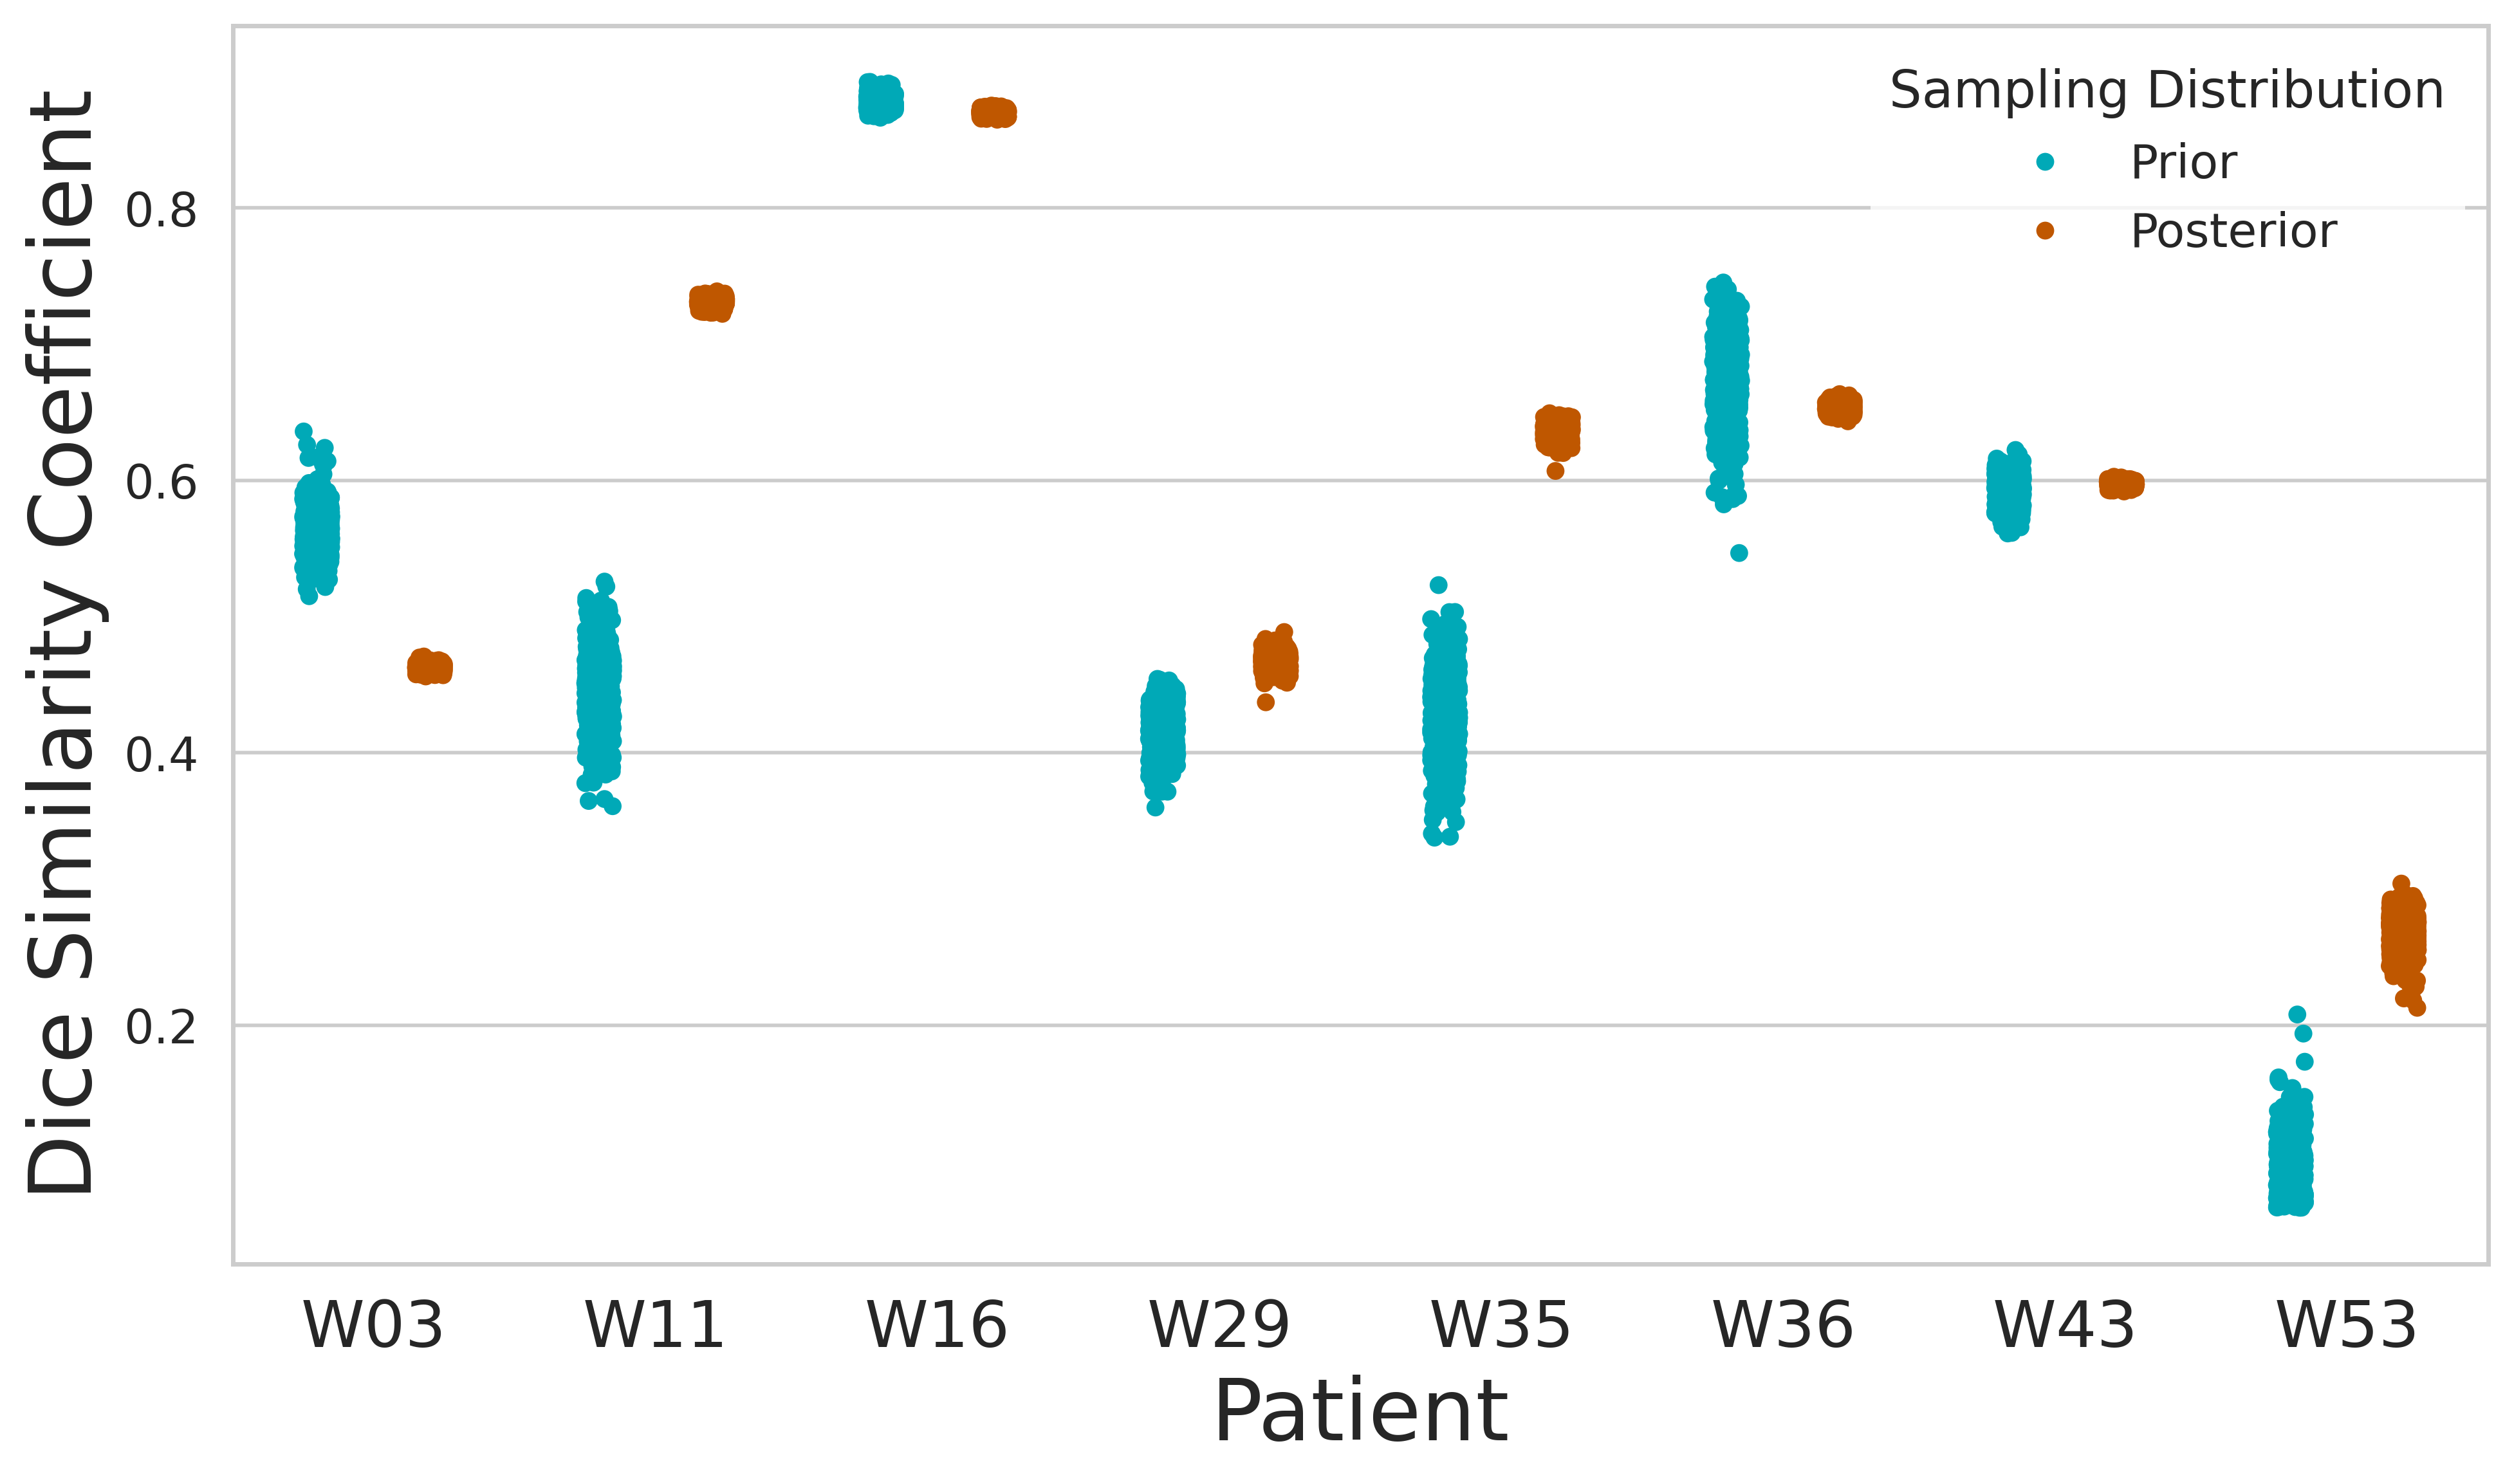

In [10]:
# Filter the data for PWRDTX and last-to-final
l2f_pwrdtx_df = dice_df[
    (dice_df["experiment_type"] == "pwrdtx") & 
    (dice_df["sample_type"] == "last-to-final")
]

# Create the plot
plt.figure(figsize=(10, 6))
sns.stripplot(
    data=l2f_pwrdtx_df,
    x="patient",
    y="value",
    hue="pred_label",
    dodge=True,
    jitter=True,
    palette=[utblue, utorange]
)

# Customize the plot
# plt.title("Relative Error in Total Tumor Cellularity Prediction")
plt.xlabel("Patient", fontsize=24)
plt.ylabel("Dice Similarity Coefficient", fontsize=24)
plt.xticks(rotation=0, fontsize=18)
plt.legend(title="Sampling Distribution")
plt.tight_layout()

# Show the plot
plt.savefig("ivygap_dice_l2f.pdf")
plt.show()

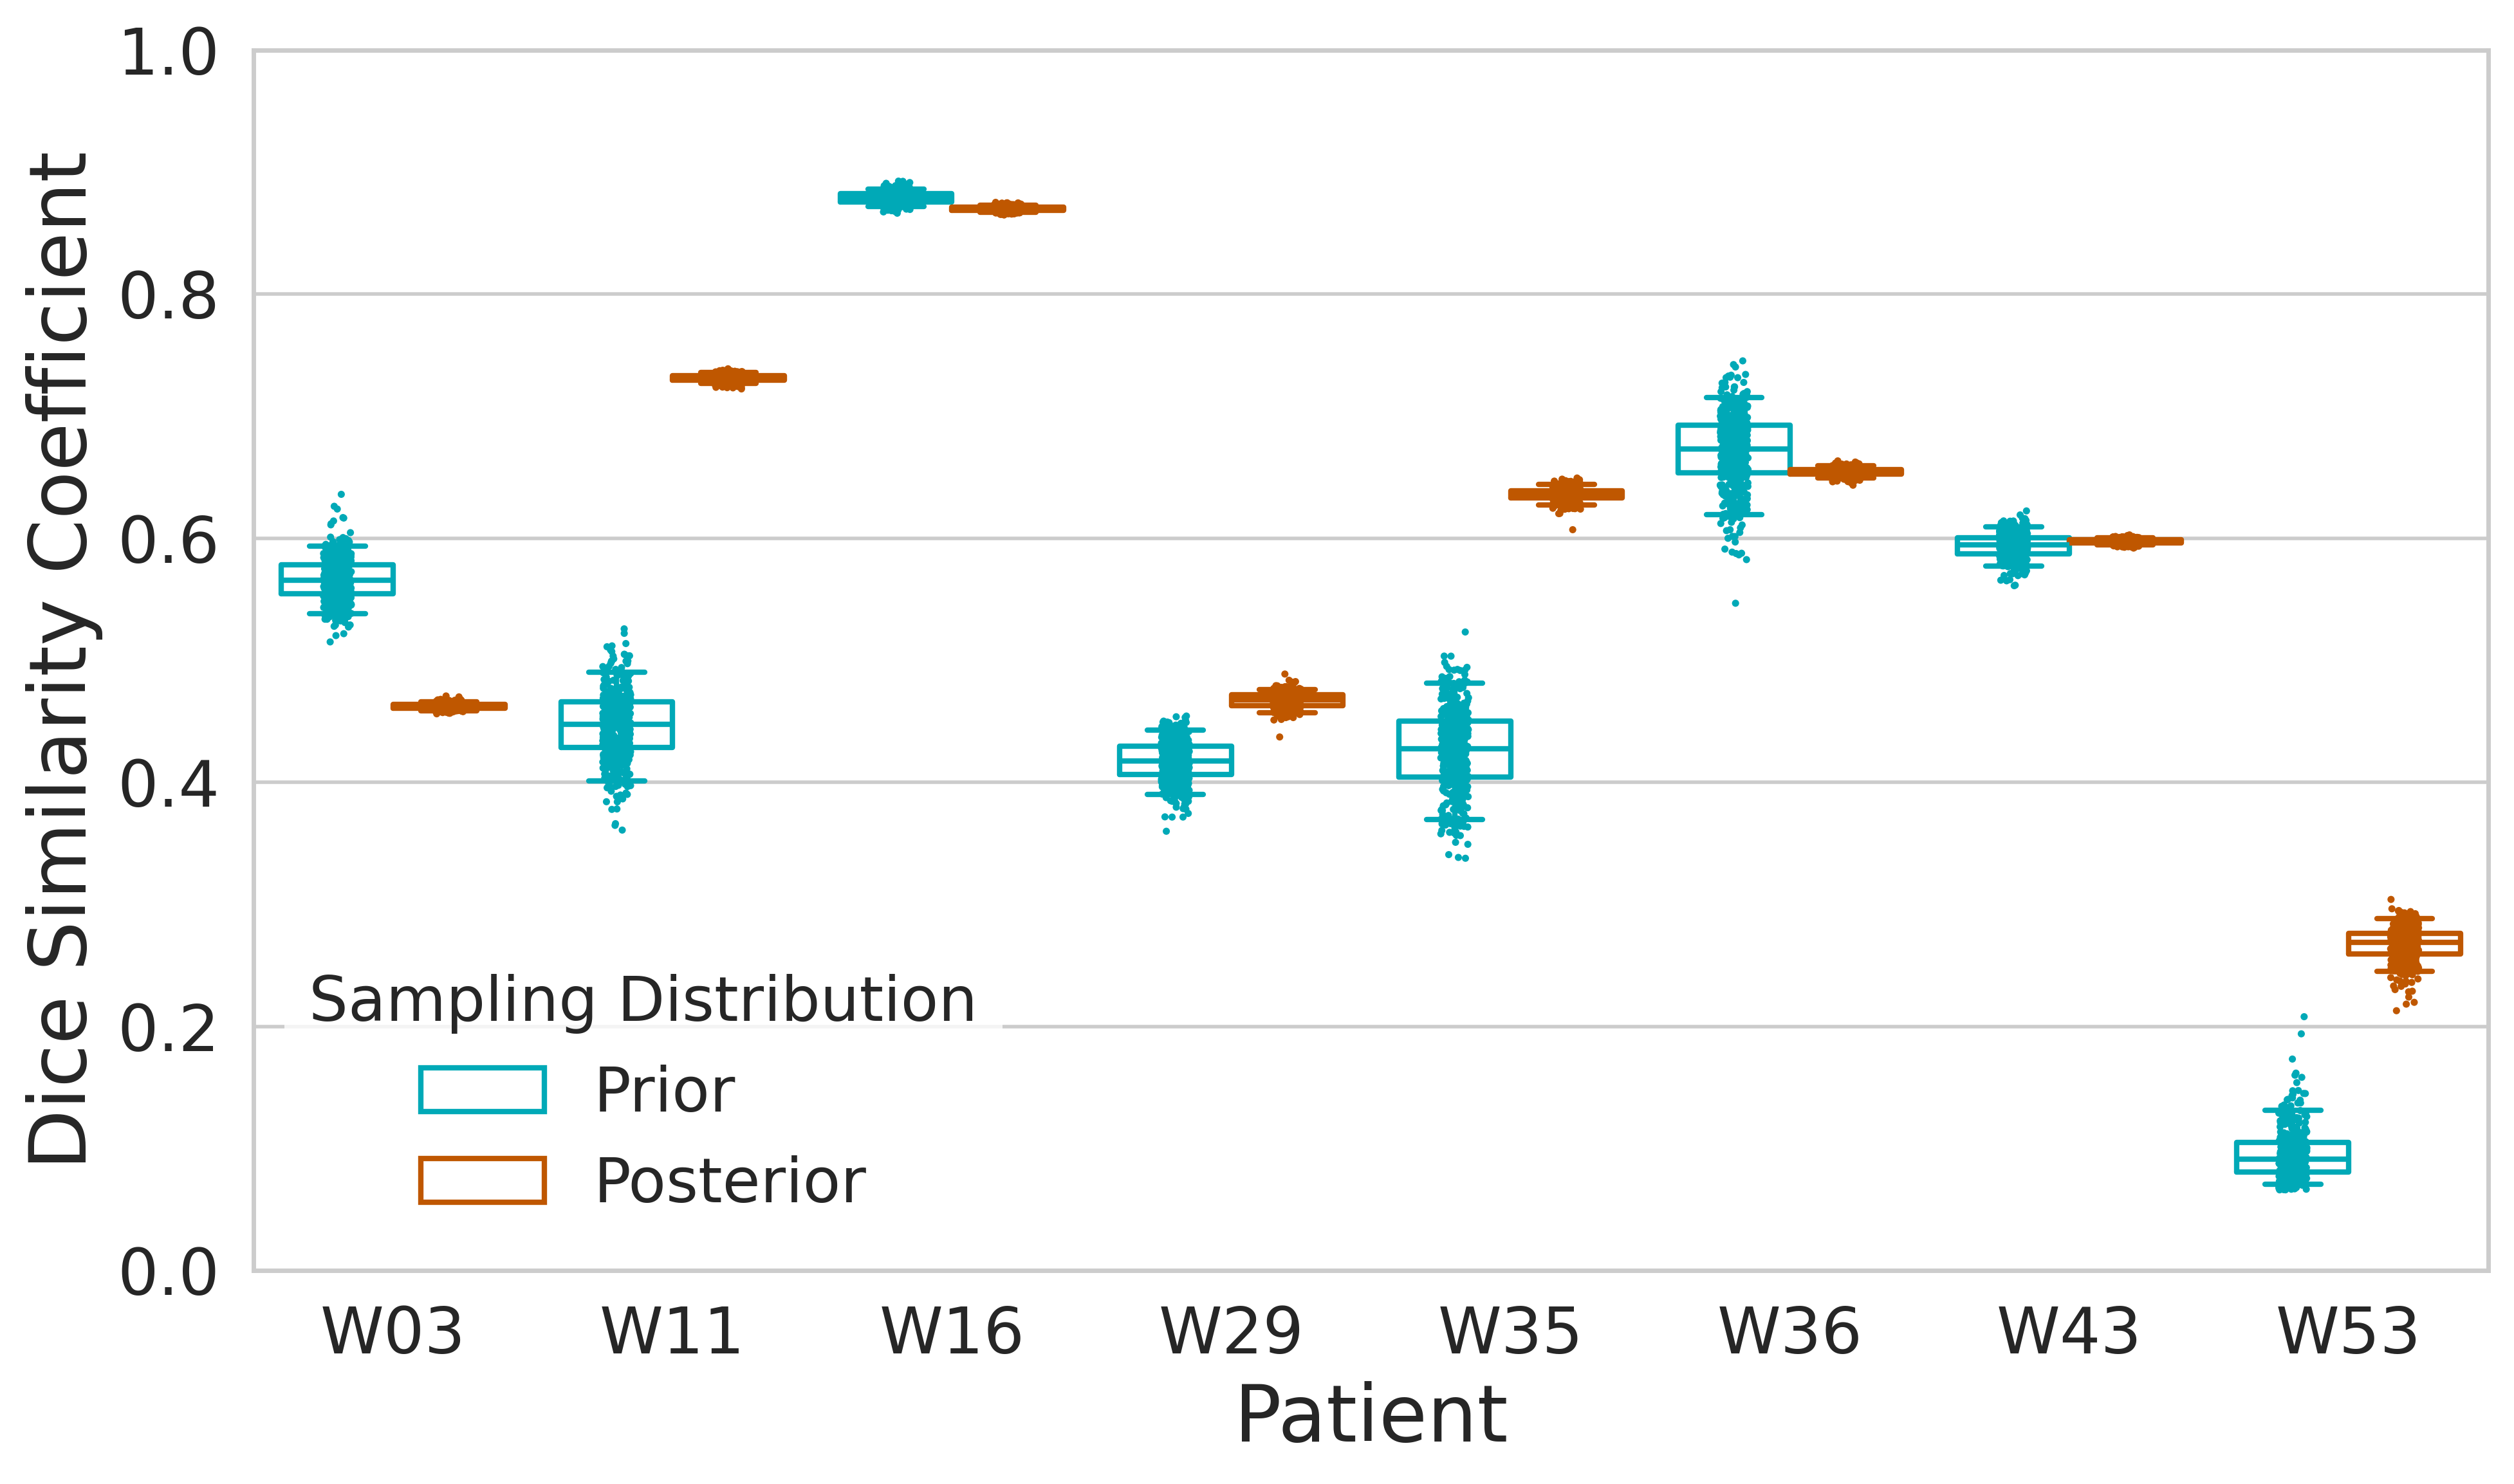

In [11]:
# Filter the data for PWRDTX and last-to-final
l2f_pwrdtx_df = dice_df[
    (dice_df["experiment_type"] == "pwrdtx") & 
    (dice_df["sample_type"] == "last-to-final")
]

# Create the plot
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=l2f_pwrdtx_df,
    x="patient",
    y="value",hue="pred_label",
    fill=False,
    palette=[utblue, utorange],
    showfliers=False,
    whis=[5, 95],
)

ax = sns.stripplot(
    data=l2f_pwrdtx_df,
    x="patient",
    y="value",
    hue="pred_label",
    dodge=True,
    jitter=True,
    palette=[utblue, utorange],
    size=2
)

# sns.violinplot(data=l2f_pwrdtx_df, x="patient", y="value", hue="pred_label", fill=False, palette=[utblue, utorange])

# Customize the plot
# plt.title("Relative Error in Total Tumor Cellularity Prediction")
plt.xlabel("Patient", fontsize=22)
plt.ylabel("Dice Similarity Coefficient", fontsize=22)
plt.xticks(rotation=0, fontsize=18)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=18)
plt.ylim(0.0, 1.0)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2], title="Sampling Distribution", fontsize='large', title_fontsize='large')
# plt.legend(title="Sampling Distribution")

plt.tight_layout()

# Show the plot
plt.savefig("ivygap_dice_l2f.pdf")
plt.show()

In [12]:
l2f_prior_stats = []
l2f_la_post_stats = []
lo = 0.05
hi = 0.95
for name in cohort:
    l2f_prior_stats.append(compute_stats(l2f_pwrdtx_df, name, "Prior", lo, hi))

for name in cohort:
    l2f_la_post_stats.append(compute_stats(l2f_pwrdtx_df, name, "Posterior", lo, hi))

Mean W03 (Prior): 0.5660500999454524
Std. Dev. W03 (Prior): 0.017613554350394554
Credible Interval (0.05, 0.95) of W03 (Prior): (0.5380821032699898, 0.5932761920914543)
Mean W11 (Prior): 0.4466108533998483
Std. Dev. W11 (Prior): 0.027609839033570862
Credible Interval (0.05, 0.95) of W11 (Prior): (0.4011120713283108, 0.490216469998828)
Mean W16 (Prior): 0.8788556698525183
Std. Dev. W16 (Prior): 0.004552170000518951
Credible Interval (0.05, 0.95) of W16 (Prior): (0.8715814236657208, 0.8860717900354071)
Mean W29 (Prior): 0.41719272585777645
Std. Dev. W29 (Prior): 0.01638362321287147
Credible Interval (0.05, 0.95) of W29 (Prior): (0.3898531260586999, 0.44280200810637044)
Mean W35 (Prior): 0.42716504883233636
Std. Dev. W35 (Prior): 0.03235953650274034
Credible Interval (0.05, 0.95) of W35 (Prior): (0.36922480747158176, 0.4810128122524675)
Mean W36 (Prior): 0.6713923524016688
Std. Dev. W36 (Prior): 0.03016374971228057
Credible Interval (0.05, 0.95) of W36 (Prior): (0.6191096657257414, 0.7152

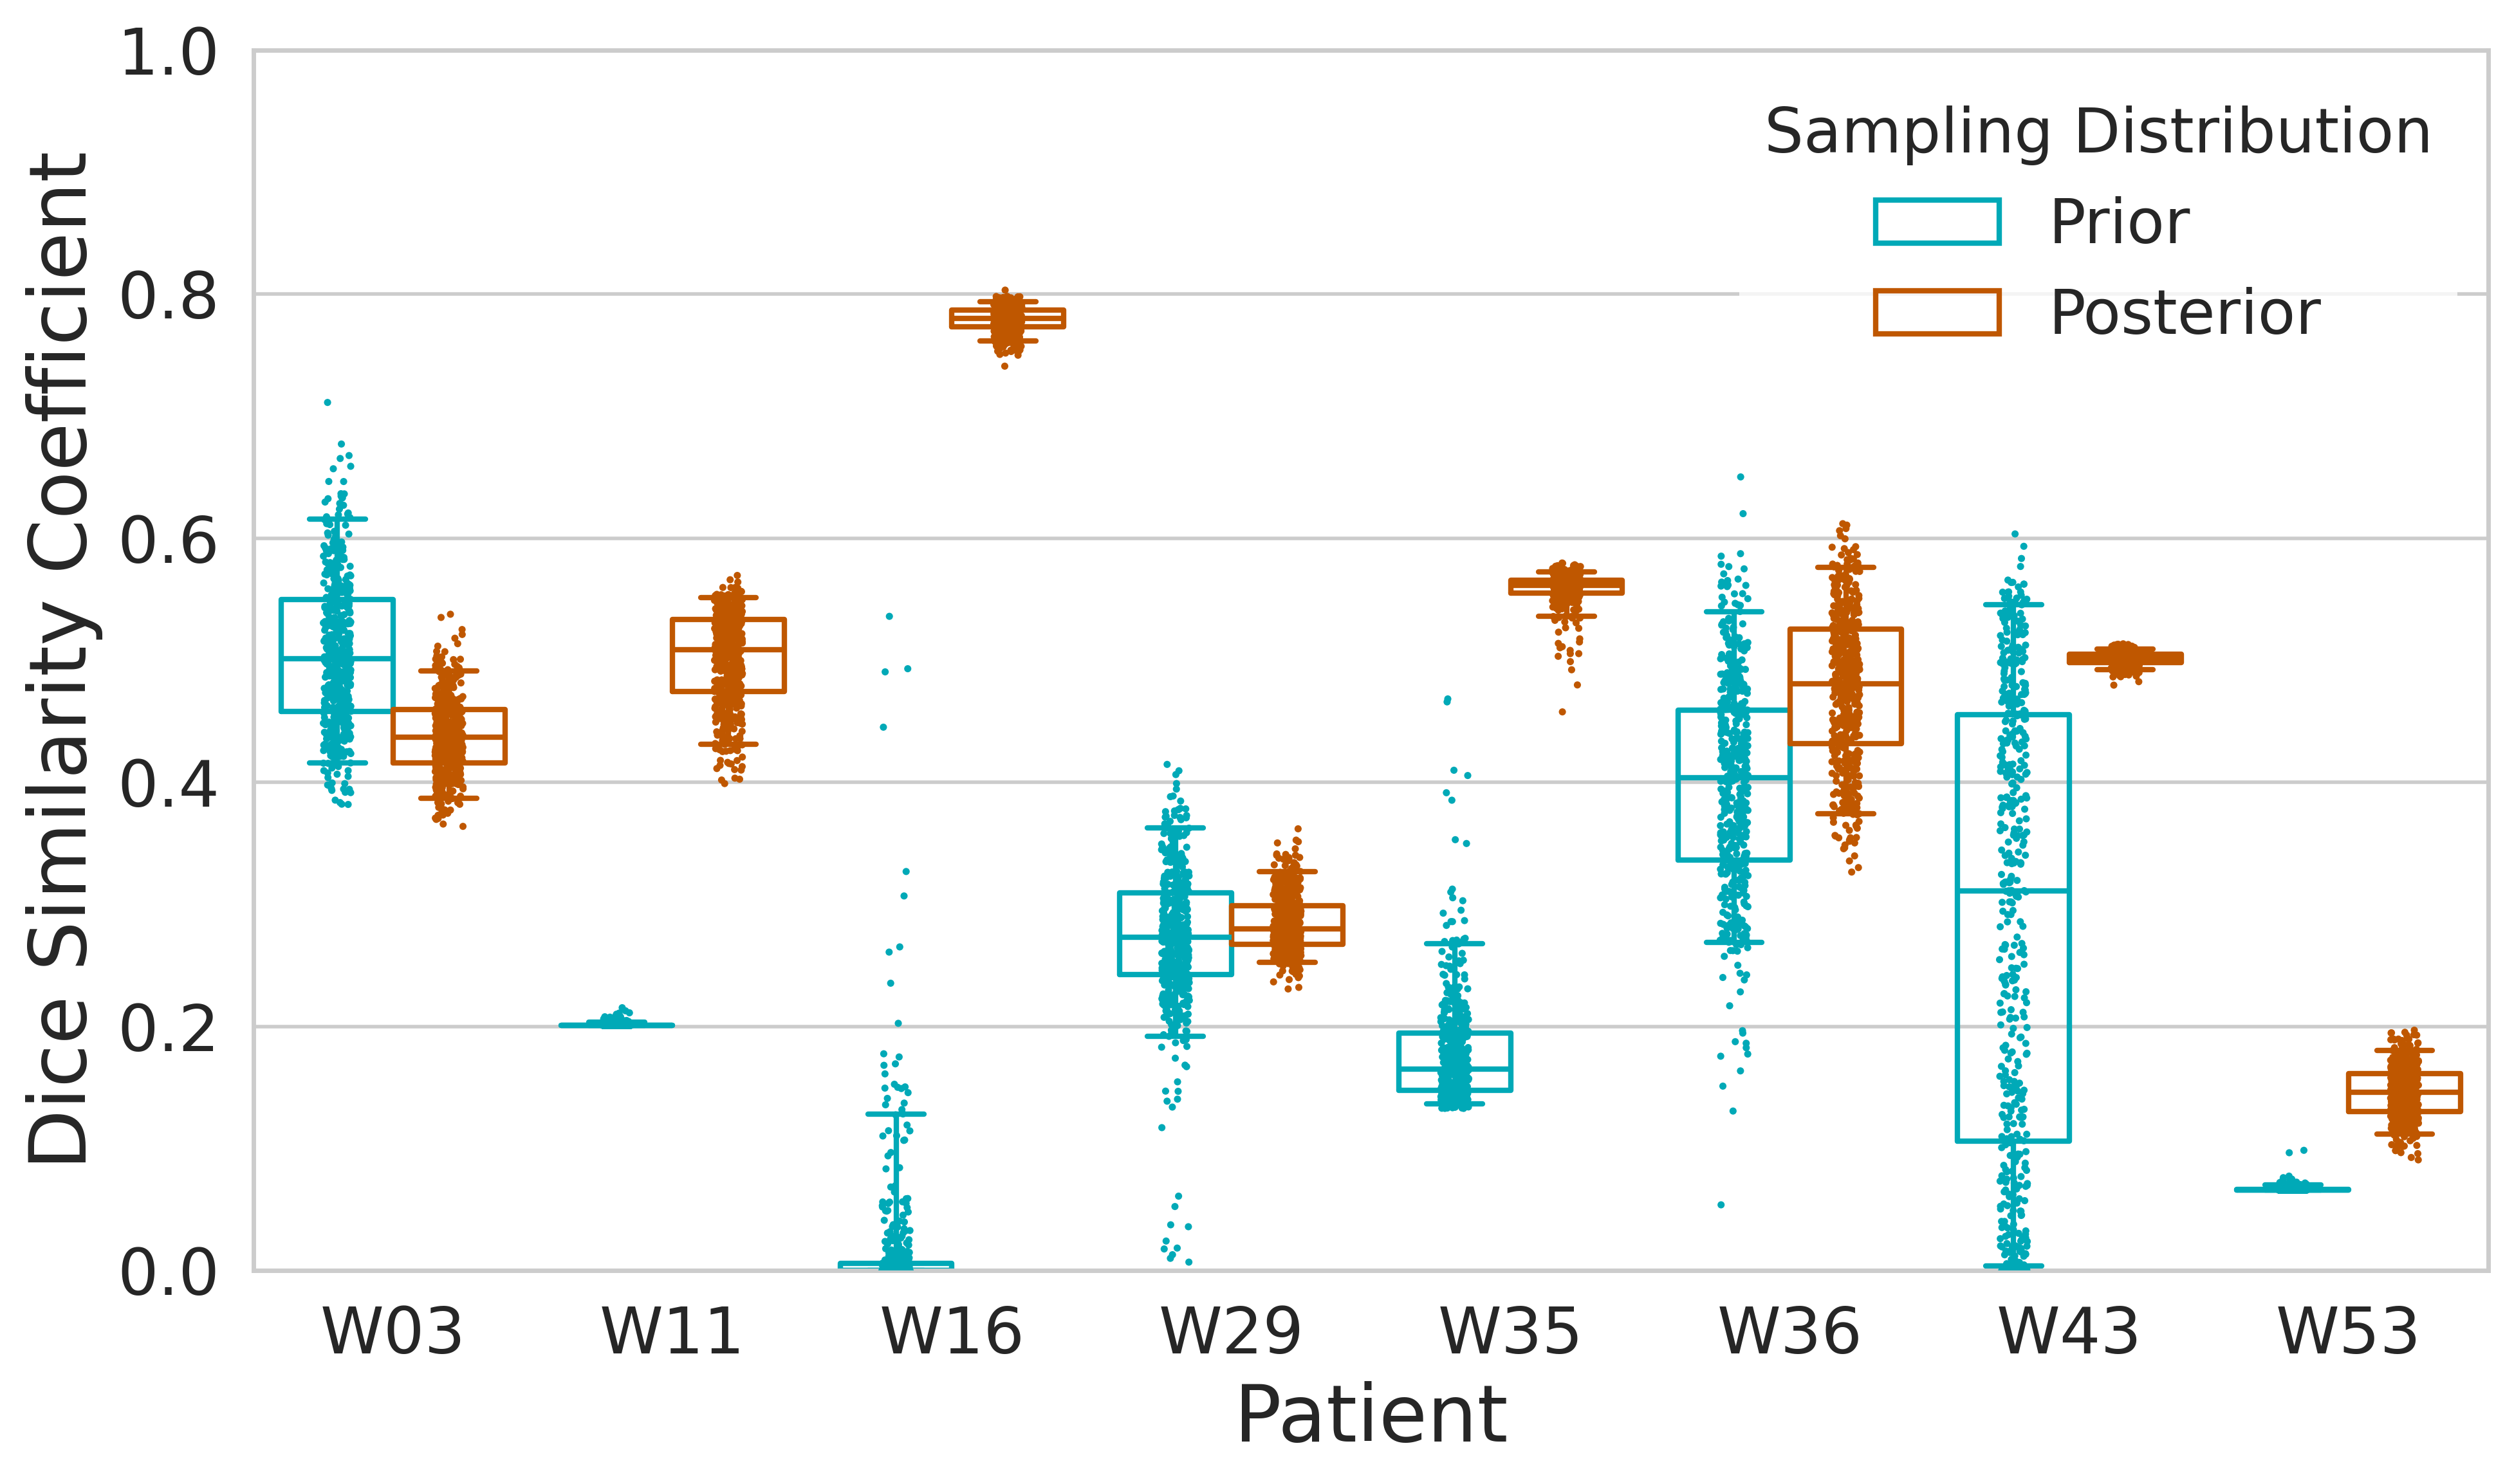

In [13]:
# Filter the data for PWRDTX and last-to-final
i2f_pwrdtx_df = dice_df[
    (dice_df["experiment_type"] == "pwrdtx") & 
    (dice_df["sample_type"] == "initial-to-final")
]

# Create the plot
plt.figure(figsize=(10, 6))

sns.boxplot(
    data=i2f_pwrdtx_df,
    x="patient",
    y="value",hue="pred_label",
    fill=False,
    palette=[utblue, utorange],
    showfliers=False,
    whis=[5, 95],
)

ax = sns.stripplot(
    data=i2f_pwrdtx_df,
    x="patient",
    y="value",
    hue="pred_label",
    dodge=True,
    jitter=True,
    palette=[utblue, utorange],
    size=2
)

# Customize the plot
# plt.title("Relative Error in Total Tumor Cellularity Prediction")
plt.xlabel("Patient", fontsize=22)
plt.ylabel("Dice Similarity Coefficient", fontsize=22)
plt.xticks(rotation=0, fontsize=18)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=18)
plt.ylim(0.0, 1.0)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2], title="Sampling Distribution", fontsize='large', title_fontsize='large')
# plt.legend(title="Sampling Distribution")

plt.tight_layout()

# Show the plot
plt.savefig("ivygap_dice_i2f.pdf")
plt.show()

In [14]:
i2f_prior_stats = []
i2f_la_post_stats = []
lo = 0.05
hi = 0.95
for name in cohort:
    i2f_prior_stats.append(compute_stats(i2f_pwrdtx_df, name, "Prior", lo, hi))

for name in cohort:
    i2f_la_post_stats.append(compute_stats(i2f_pwrdtx_df, name, "Posterior", lo, hi))

Mean W03 (Prior): 0.5063736095166612
Std. Dev. W03 (Prior): 0.06141348778051775
Credible Interval (0.05, 0.95) of W03 (Prior): (0.4156554838626507, 0.6157720115349199)
Mean W11 (Prior): 0.2012083935107198
Std. Dev. W11 (Prior): 0.0014634590932617979
Credible Interval (0.05, 0.95) of W11 (Prior): (0.20080546329281335, 0.2033066393713574)
Mean W16 (Prior): 0.01937432003127509
Std. Dev. W16 (Prior): 0.06018046469827597
Credible Interval (0.05, 0.95) of W16 (Prior): (0.0, 0.12841116308888123)
Mean W29 (Prior): 0.2720750192932929
Std. Dev. W29 (Prior): 0.06019100664548139
Credible Interval (0.05, 0.95) of W29 (Prior): (0.19170462598034452, 0.3624047853750841)
Mean W35 (Prior): 0.17843910237564567
Std. Dev. W35 (Prior): 0.046234760563229296
Credible Interval (0.05, 0.95) of W35 (Prior): (0.13659183390096774, 0.2676489062117124)
Mean W36 (Prior): 0.3982616824193454
Std. Dev. W36 (Prior): 0.08765437129362989
Credible Interval (0.05, 0.95) of W36 (Prior): (0.2688286683285655, 0.540181772072952)

#### Visualize all results across all experiments.

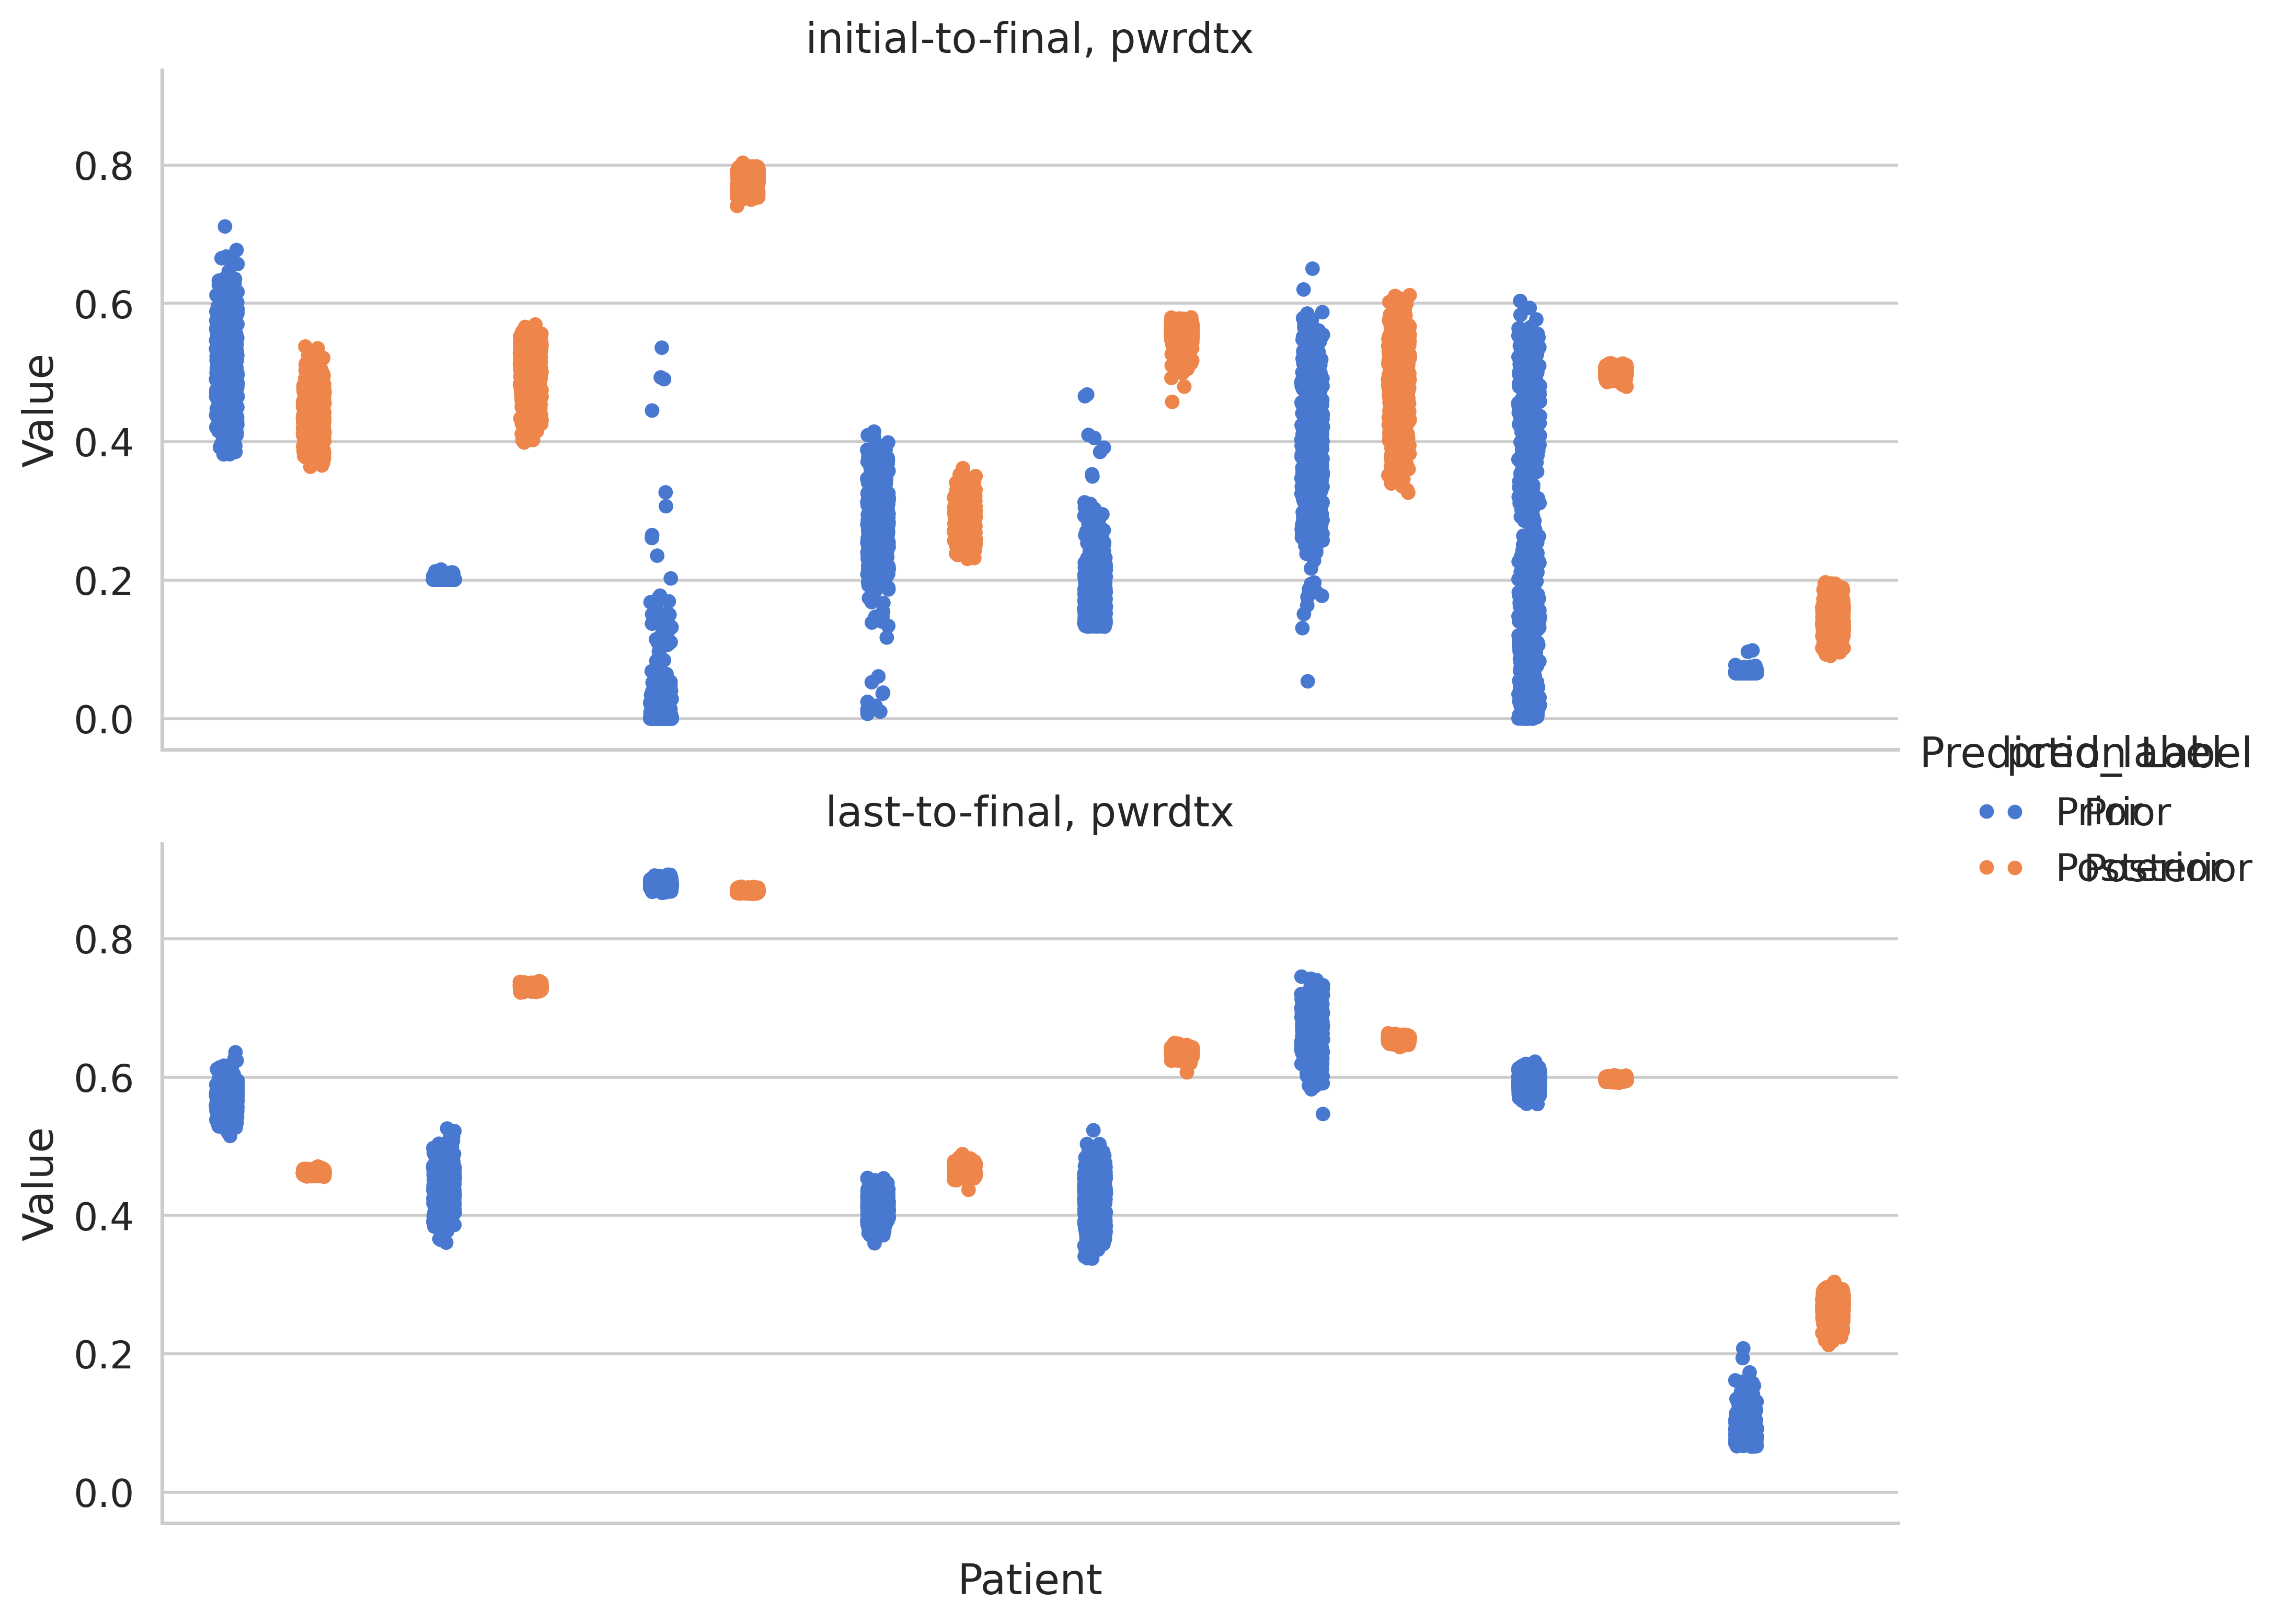

In [15]:
# Create the strip plot with FacetGrid to separate by sample_type and pred_label
g = sns.catplot(
    data=dice_df,
    x='patient', 
    y='value', 
    hue='pred_label',  # Different colors for Posterior vs. Prior
    kind='strip', 
    dodge=True,  # Separate points for different pred_label
    row='sample_type',  # Separate rows by initial-to-final vs last-to-final
    col='experiment_type',  # Separate columns by experiment type
    height=4, 
    aspect=2  # Adjust width
)

# Customize the plot
g.set_axis_labels("Patient", "Value")
g.set_titles("{row_name}, {col_name}")  # Titles for each facet
g.set_xticklabels(rotation=90)  # Rotate patient names for better readability
g.tight_layout()

# Add a legend
g.add_legend(title="Prediction Label")

# Show the plot
plt.show()


## Total Tumor Cellularity

In [16]:
ttc_true = get_predictives(cohort, 'dmpwrdtx', 'ttc_true', l2f=True)

# last-to-final data
if PROCESS_RD:
    l2f_rd_post_ttc = get_predictives(cohort, 'dmrd', 'la_post_ttc', l2f=True)
    l2f_rd_prior_ttc = get_predictives(cohort, 'dmrd', 'prior_ttc', l2f=True)

if PROCESS_RDTX:
    l2f_rdtx_post_ttc = get_predictives(cohort, 'dmrdtx', 'la_post_ttc', l2f=True)
    l2f_rdtx_prior_ttc = get_predictives(cohort, 'dmrdtx', 'prior_ttc', l2f=True)

if PROCESS_PWRDTX:
    l2f_pwrdtx_post_ttc = get_predictives(cohort, 'dmpwrdtx', 'la_post_ttc', l2f=True)
    l2f_pwrdtx_prior_ttc = get_predictives(cohort, 'dmpwrdtx', 'prior_ttc', l2f=True)

# initial-to-final data
if PROCESS_RD:
    i2f_rd_post_ttc = get_predictives(cohort, 'dmrd', 'dice', 'la_post', l2f=False)
    i2f_rd_prior_ttc = get_predictives(cohort, 'dmrd', 'dice', 'prior', l2f=False)

if PROCESS_RDTX:
    i2f_rdtx_post_ttc = get_predictives(cohort, 'dmrdtx', 'la_post_ttc', l2f=False)
    i2f_rdtx_prior_ttc = get_predictives(cohort, 'dmrdtx', 'prior_ttc', l2f=False)

if PROCESS_PWRDTX:
    i2f_pwrdtx_post_ttc = get_predictives(cohort, 'dmpwrdtx', 'la_post_ttc', l2f=False)
    i2f_pwrdtx_prior_ttc = get_predictives(cohort, 'dmpwrdtx', 'prior_ttc', l2f=False)

In [17]:
import numpy as np

# Compute relative errors for last-to-final data
if PROCESS_RD:
    l2f_rd_post_ttc_error = compute_relative_error(ttc_true, l2f_rd_post_ttc)
    l2f_rd_prior_ttc_error = compute_relative_error(ttc_true, l2f_rd_prior_ttc)

if PROCESS_RDTX:
    l2f_rdtx_post_ttc_error = compute_relative_error(ttc_true, l2f_rdtx_post_ttc)
    l2f_rdtx_prior_ttc_error = compute_relative_error(ttc_true, l2f_rdtx_prior_ttc)

if PROCESS_PWRDTX:
    l2f_pwrdtx_post_ttc_error = compute_relative_error(ttc_true, l2f_pwrdtx_post_ttc)
    l2f_pwrdtx_prior_ttc_error = compute_relative_error(ttc_true, l2f_pwrdtx_prior_ttc)

# Compute relative errors for initial-to-final data
if PROCESS_RD:
    i2f_rd_post_ttc_error = compute_relative_error(ttc_true, i2f_rd_post_ttc)
    i2f_rd_prior_ttc_error = compute_relative_error(ttc_true, i2f_rd_prior_ttc)

if PROCESS_RDTX:
    i2f_rdtx_post_ttc_error = compute_relative_error(ttc_true, i2f_rdtx_post_ttc)
    i2f_rdtx_prior_ttc_error = compute_relative_error(ttc_true, i2f_rdtx_prior_ttc)

if PROCESS_PWRDTX:
    i2f_pwrdtx_post_ttc_error = compute_relative_error(ttc_true, i2f_pwrdtx_post_ttc)
    i2f_pwrdtx_prior_ttc_error = compute_relative_error(ttc_true, i2f_pwrdtx_prior_ttc)


In [18]:
# Reuse the existing create_dataframe function to create the DataFrame
data_frames = []

# Last-to-final data
if PROCESS_RD:
    data_frames.append(create_dataframe(cohort, l2f_rd_post_ttc_error, 'last-to-final', 'Posterior', 'rd'))
    data_frames.append(create_dataframe(cohort, l2f_rd_prior_ttc_error, 'last-to-final', 'Prior', 'rd'))
if PROCESS_RDTX:
    data_frames.append(create_dataframe(cohort, l2f_rdtx_post_ttc_error, 'last-to-final', 'Posterior', 'rdtx'))
    data_frames.append(create_dataframe(cohort, l2f_rdtx_prior_ttc_error, 'last-to-final', 'Prior', 'rdtx'))
if PROCESS_PWRDTX:
    data_frames.append(create_dataframe(cohort, l2f_pwrdtx_post_ttc_error, 'last-to-final', 'Posterior', 'pwrdtx'))
    data_frames.append(create_dataframe(cohort, l2f_pwrdtx_prior_ttc_error, 'last-to-final', 'Prior', 'pwrdtx'))

# Initial-to-final data
if PROCESS_RD:
    data_frames.append(create_dataframe(cohort, i2f_rd_post_ttc_error, 'initial-to-final', 'Posterior', 'rd'))
    data_frames.append(create_dataframe(cohort, i2f_rd_prior_ttc_error, 'initial-to-final', 'Prior', 'rd'))
if PROCESS_RDTX:
    data_frames.append(create_dataframe(cohort, i2f_rdtx_post_ttc_error, 'initial-to-final', 'Posterior', 'rdtx'))
    data_frames.append(create_dataframe(cohort, i2f_rdtx_prior_ttc_error, 'initial-to-final', 'Prior', 'rdtx'))
if PROCESS_PWRDTX:
    data_frames.append(create_dataframe(cohort, i2f_pwrdtx_post_ttc_error, 'initial-to-final', 'Posterior', 'pwrdtx'))
    data_frames.append(create_dataframe(cohort, i2f_pwrdtx_prior_ttc_error, 'initial-to-final', 'Prior', 'pwrdtx'))

# Concatenate all data frames
relative_error_df = pd.concat(data_frames, ignore_index=True)

# Convert columns to category for efficient storage and processing
relative_error_df['patient'] = pd.Categorical(relative_error_df['patient'], categories=sorted(relative_error_df['patient'].unique()), ordered=True)
relative_error_df['sample_type'] = relative_error_df['sample_type'].astype('category')
relative_error_df['pred_label'] = relative_error_df['pred_label'].astype('category')
relative_error_df['experiment_type'] = relative_error_df['experiment_type'].astype('category')

relative_error_df["pred_label"] = pd.Categorical(
    relative_error_df["pred_label"], 
    categories=["Prior", "Posterior"],  # Change the order here
    ordered=True
)

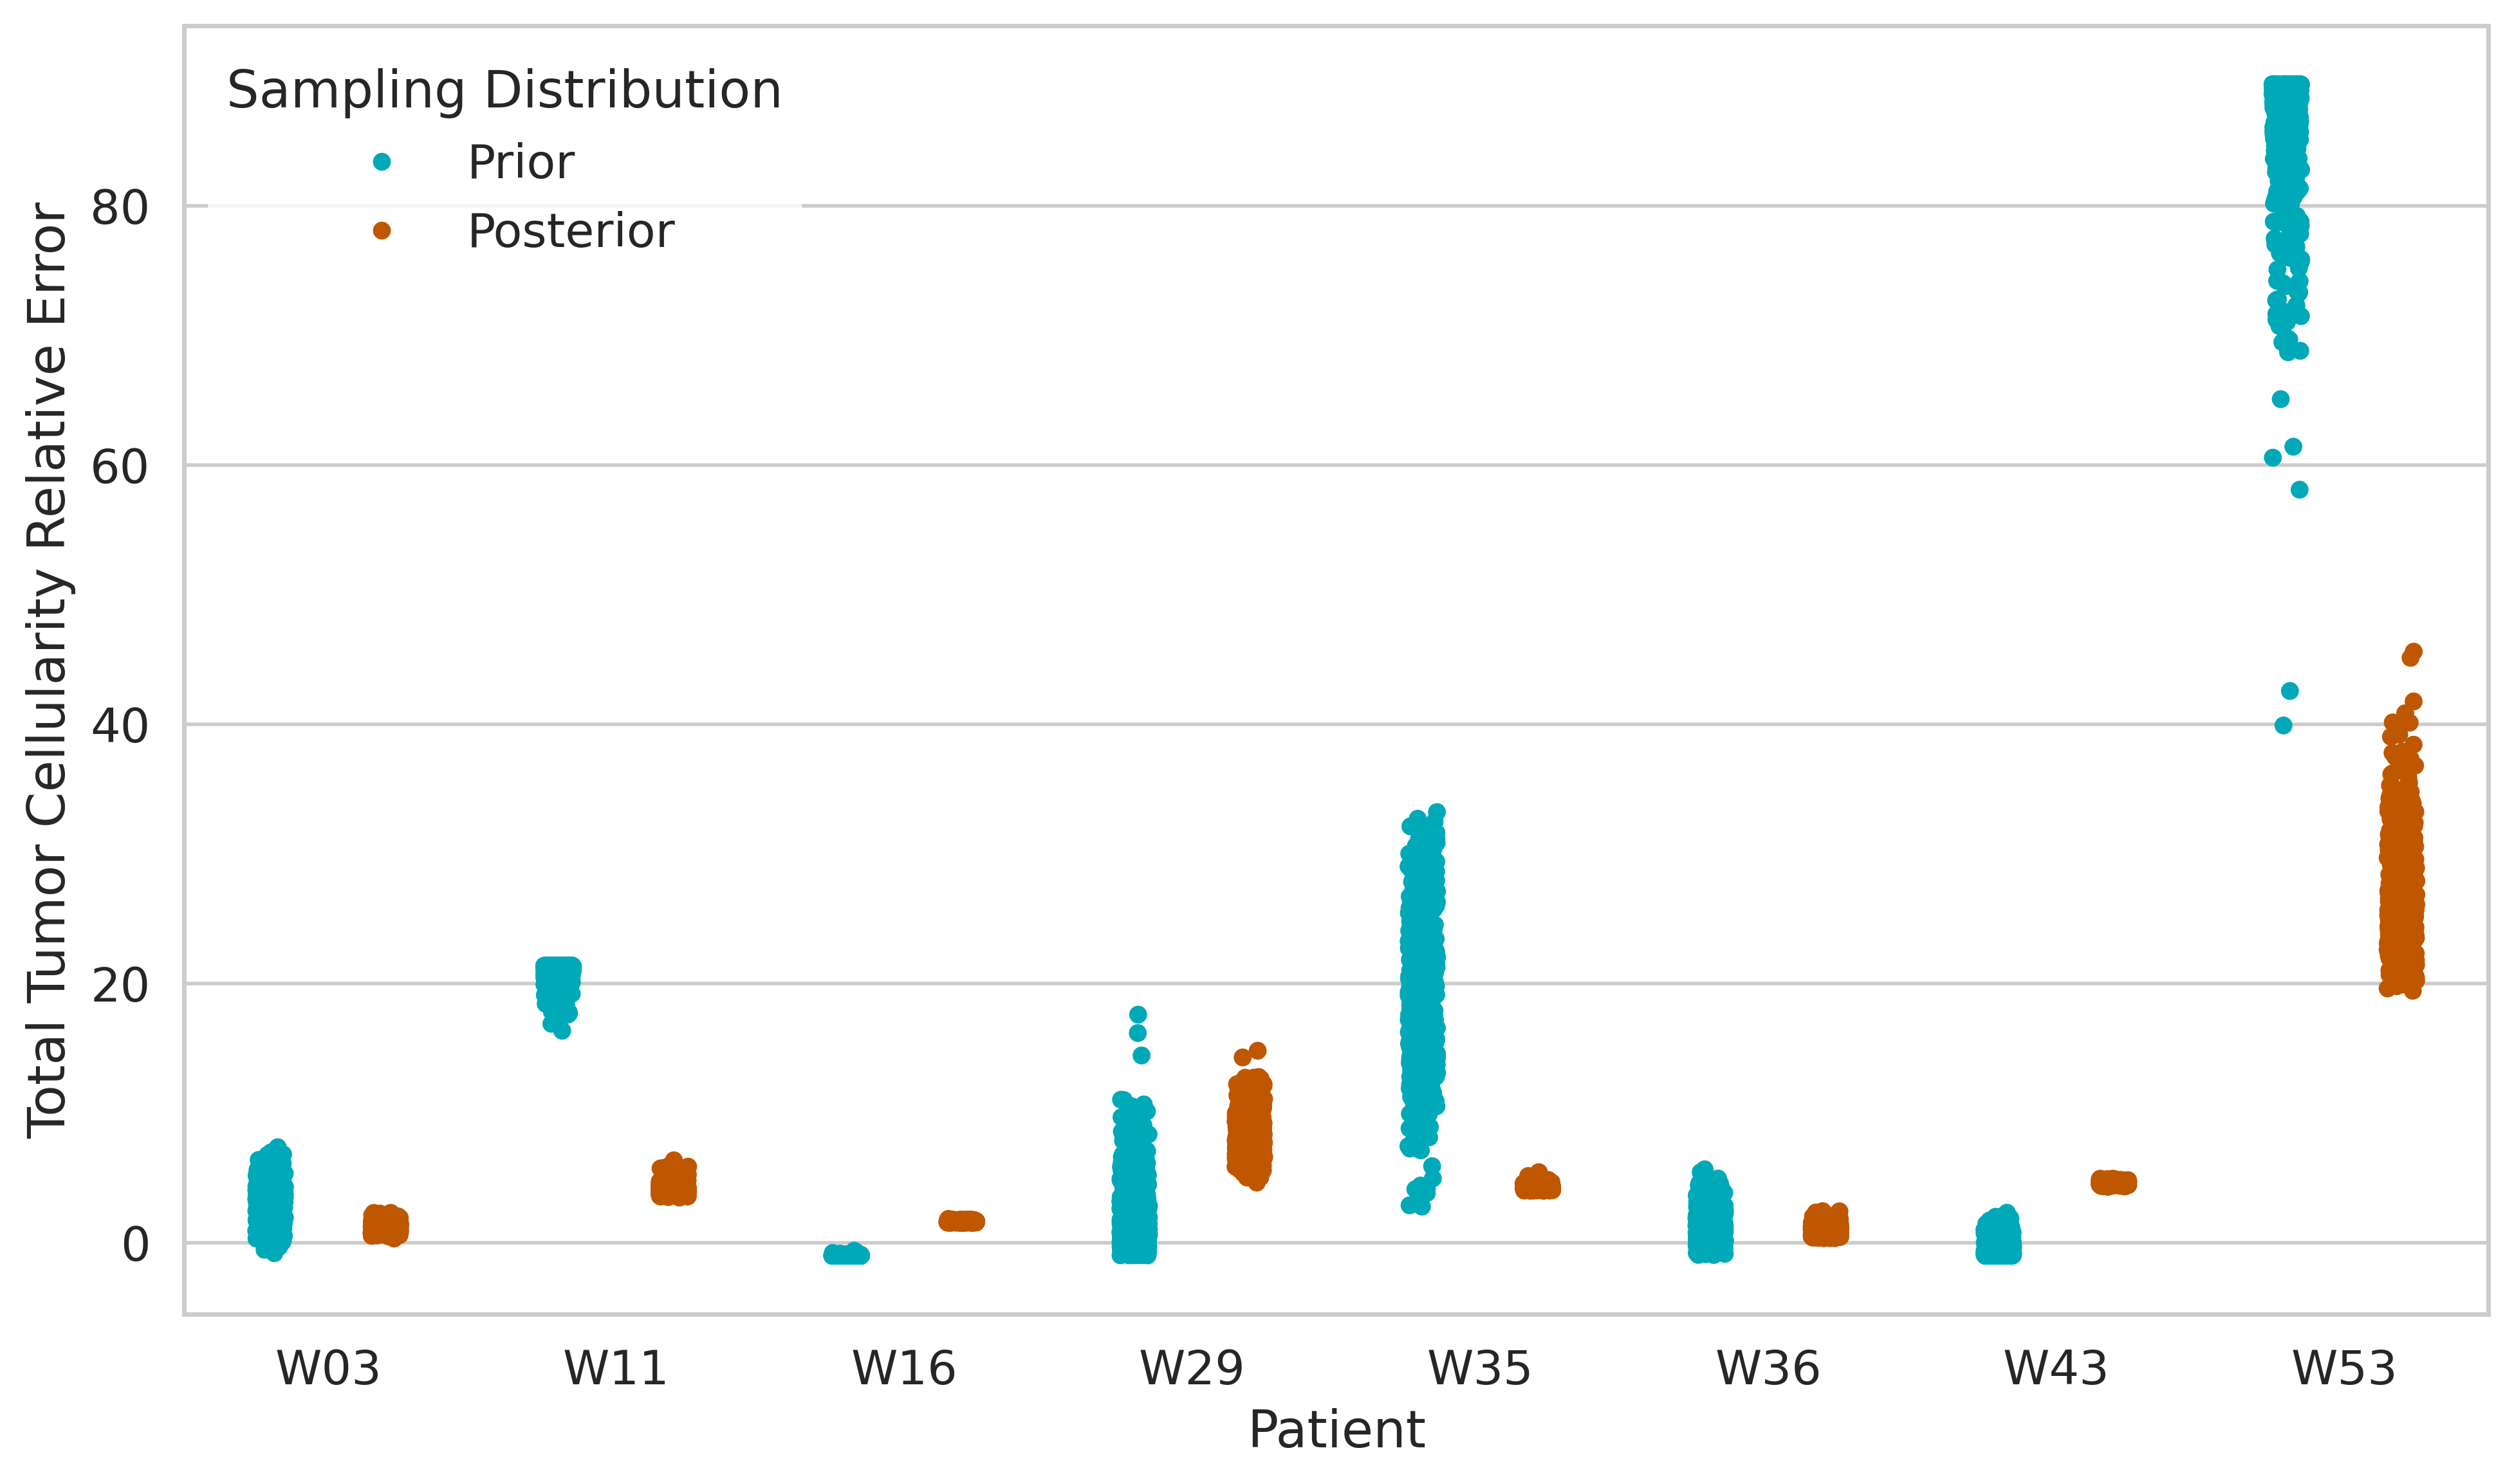

In [19]:
# Filter the data for PWRDTX and initial-to-final
i2f_pwrdtx_df = relative_error_df[
    (relative_error_df["experiment_type"] == "pwrdtx") & 
    (relative_error_df["sample_type"] == "initial-to-final")
]

# Create the plot
plt.figure(figsize=(10, 6))
sns.stripplot(
    data=i2f_pwrdtx_df,
    x="patient",
    y="value",
    hue="pred_label",
    dodge=True,
    jitter=True,
    palette=[utblue, utorange]
)

# Customize the plot
# plt.title("Relative Error in Total Tumor Cellularity Prediction")
plt.xlabel("Patient")
plt.ylabel("Total Tumor Cellularity Relative Error")
plt.xticks(rotation=0)
plt.legend(title="Sampling Distribution")
plt.tight_layout()

# Show the plot
plt.savefig("ivygap_ttc_i2f.pdf")
plt.show()

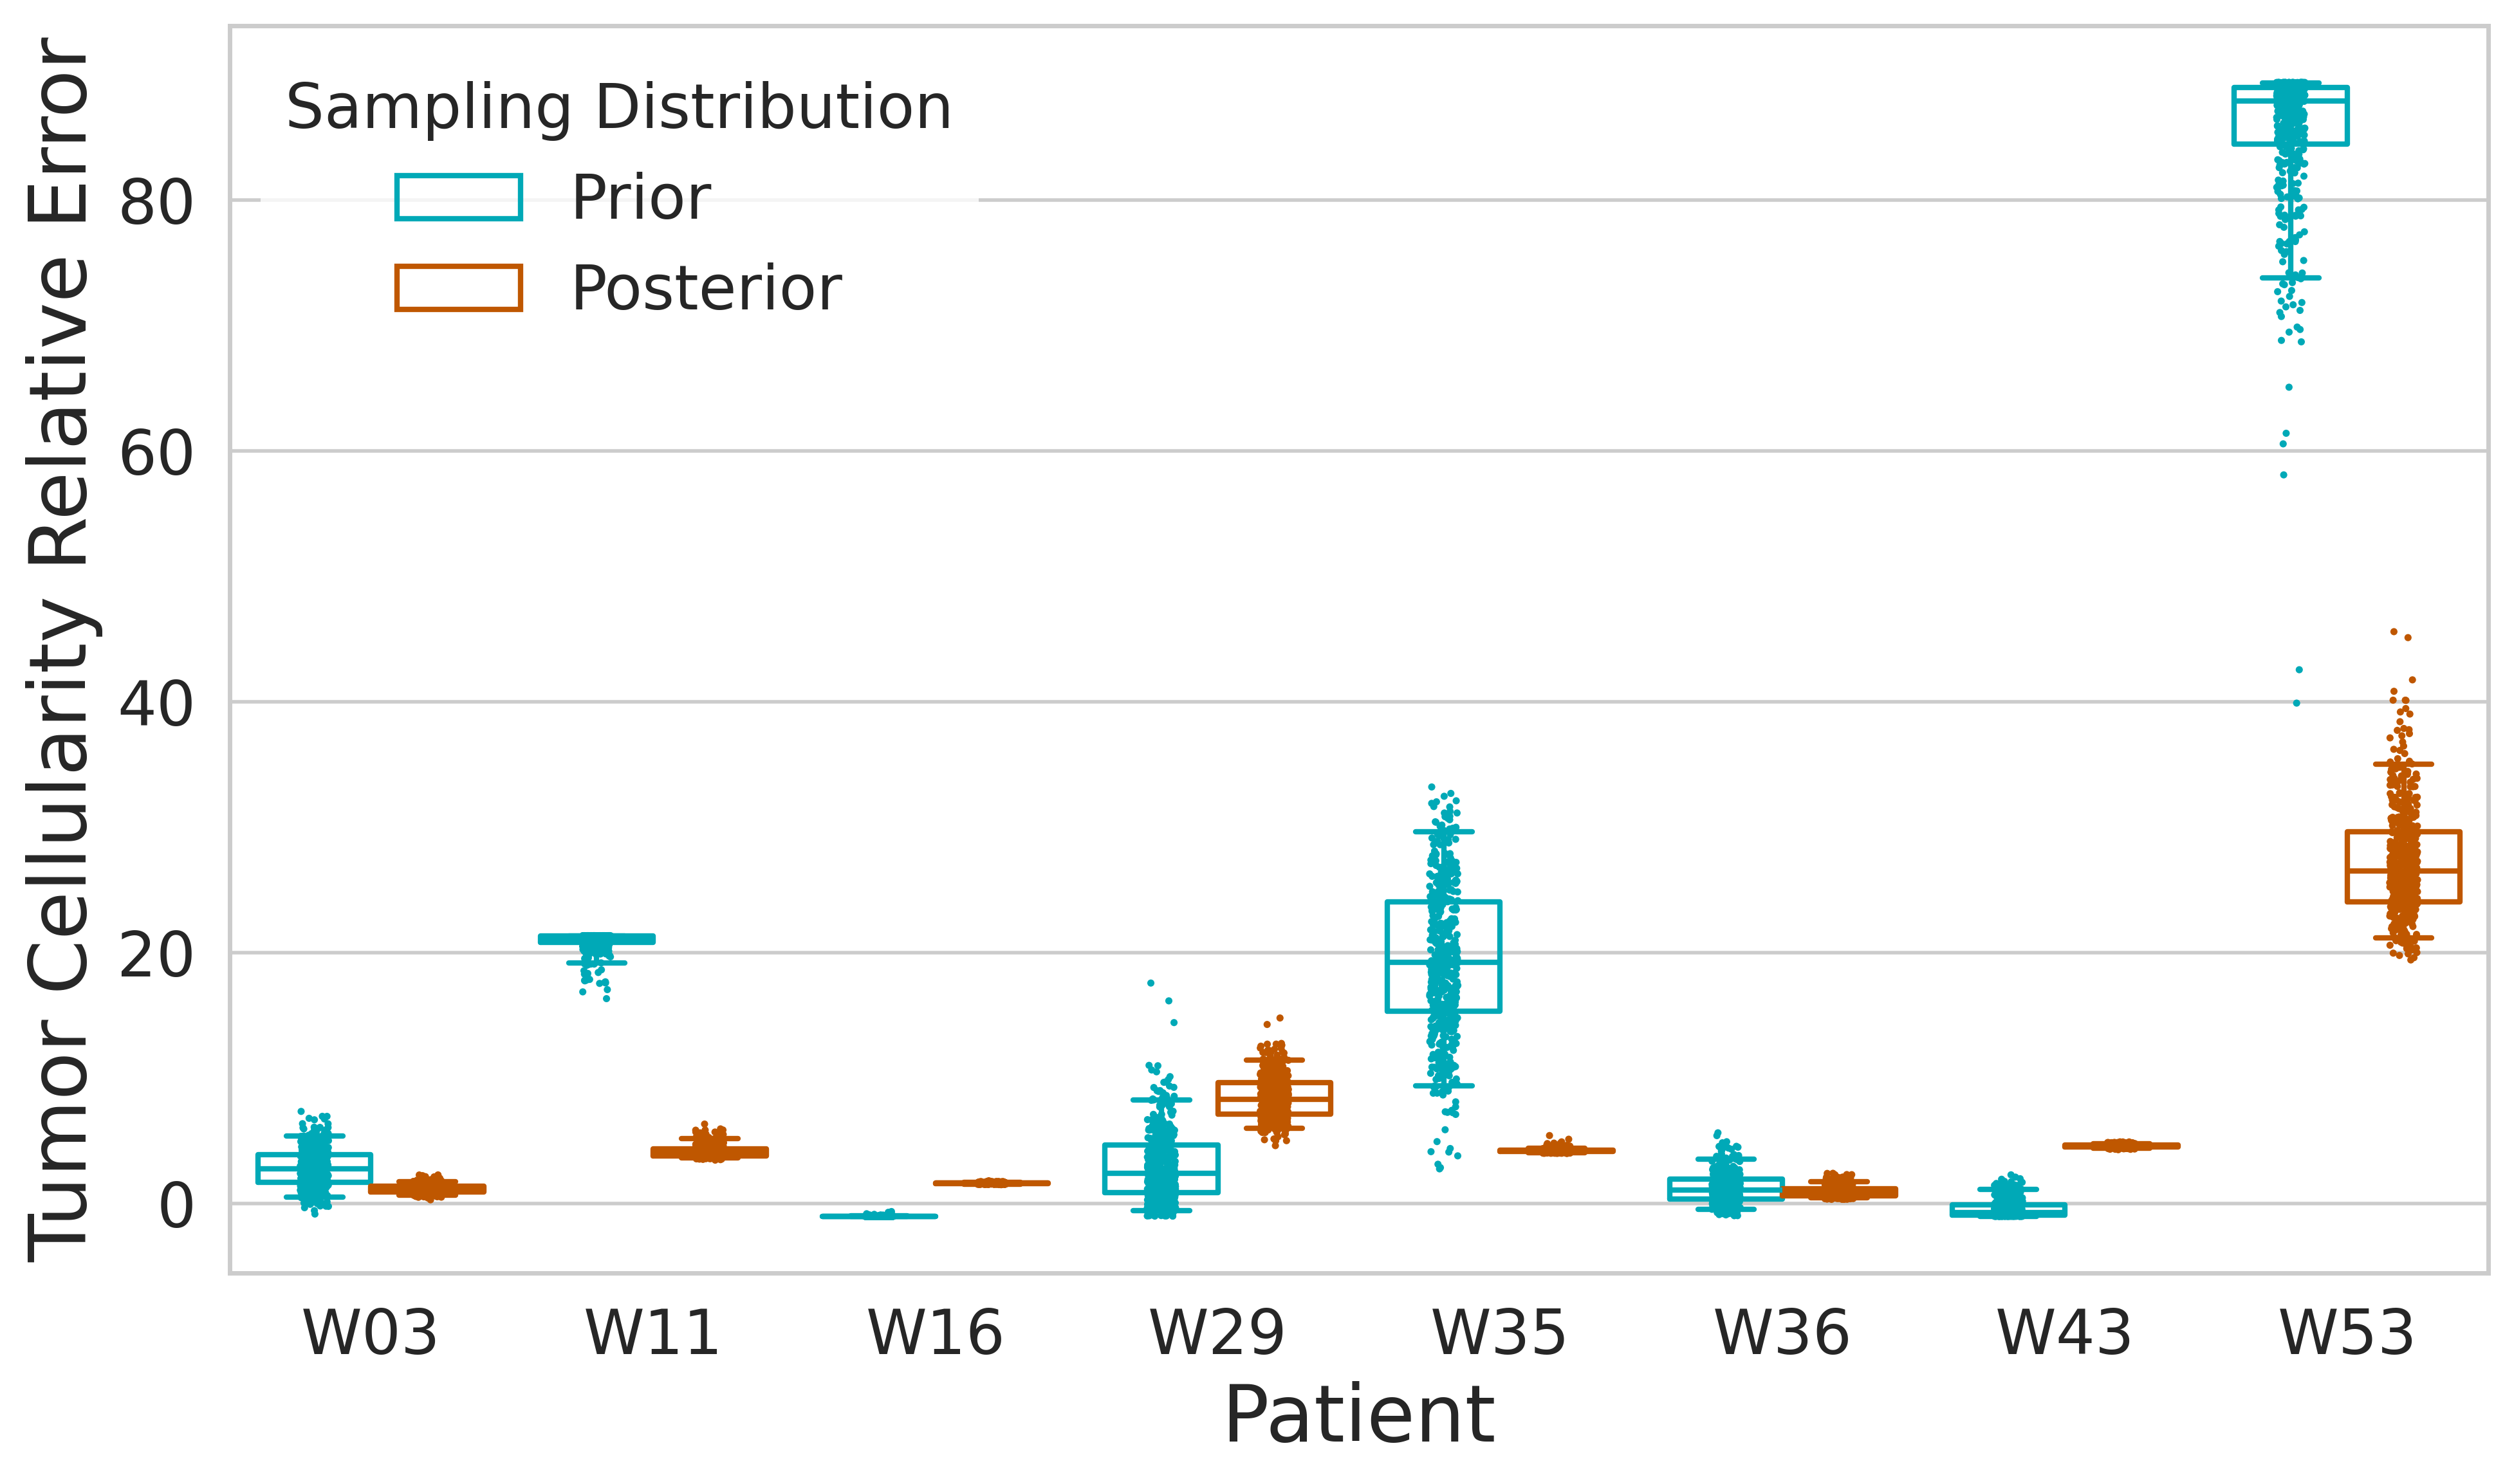

In [20]:
# Filter the data for PWRDTX and initial-to-final
i2f_pwrdtx_df = relative_error_df[
    (relative_error_df["experiment_type"] == "pwrdtx") & 
    (relative_error_df["sample_type"] == "initial-to-final")
]

# Create the plot
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=i2f_pwrdtx_df,
    x="patient",
    y="value",hue="pred_label",
    fill=False,
    palette=[utblue, utorange],
    showfliers=False,
    whis=[5, 95],
)

ax = sns.stripplot(
    data=i2f_pwrdtx_df,
    x="patient",
    y="value",
    hue="pred_label",
    dodge=True,
    jitter=True,
    palette=[utblue, utorange],
    size=2
)

# Customize the plot
# plt.title("Relative Error in Total Tumor Cellularity Prediction")
plt.xlabel("Patient", fontsize=22)
plt.ylabel("Tumor Cellularity Relative Error", fontsize=22)
plt.xticks(rotation=0, fontsize='large')
plt.yticks(fontsize='large')

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2], title="Sampling Distribution", fontsize='large', title_fontsize='large')
# plt.legend(title="Sampling Distribution")

plt.tight_layout()

# Show the plot
plt.savefig("ivygap_ttc_i2f.pdf")
plt.show()

In [21]:
l2f_prior_stats = []
l2f_la_post_stats = []
lo = 0.05
hi = 0.95
for name in cohort:
    l2f_prior_stats.append(compute_stats(l2f_pwrdtx_df, name, "Prior", lo, hi))

for name in cohort:
    l2f_la_post_stats.append(compute_stats(l2f_pwrdtx_df, name, "Posterior", lo, hi))

Mean W03 (Prior): 0.5660500999454524
Std. Dev. W03 (Prior): 0.017613554350394554
Credible Interval (0.05, 0.95) of W03 (Prior): (0.5380821032699898, 0.5932761920914543)
Mean W11 (Prior): 0.4466108533998483
Std. Dev. W11 (Prior): 0.027609839033570862
Credible Interval (0.05, 0.95) of W11 (Prior): (0.4011120713283108, 0.490216469998828)
Mean W16 (Prior): 0.8788556698525183
Std. Dev. W16 (Prior): 0.004552170000518951
Credible Interval (0.05, 0.95) of W16 (Prior): (0.8715814236657208, 0.8860717900354071)
Mean W29 (Prior): 0.41719272585777645
Std. Dev. W29 (Prior): 0.01638362321287147
Credible Interval (0.05, 0.95) of W29 (Prior): (0.3898531260586999, 0.44280200810637044)
Mean W35 (Prior): 0.42716504883233636
Std. Dev. W35 (Prior): 0.03235953650274034
Credible Interval (0.05, 0.95) of W35 (Prior): (0.36922480747158176, 0.4810128122524675)
Mean W36 (Prior): 0.6713923524016688
Std. Dev. W36 (Prior): 0.03016374971228057
Credible Interval (0.05, 0.95) of W36 (Prior): (0.6191096657257414, 0.7152

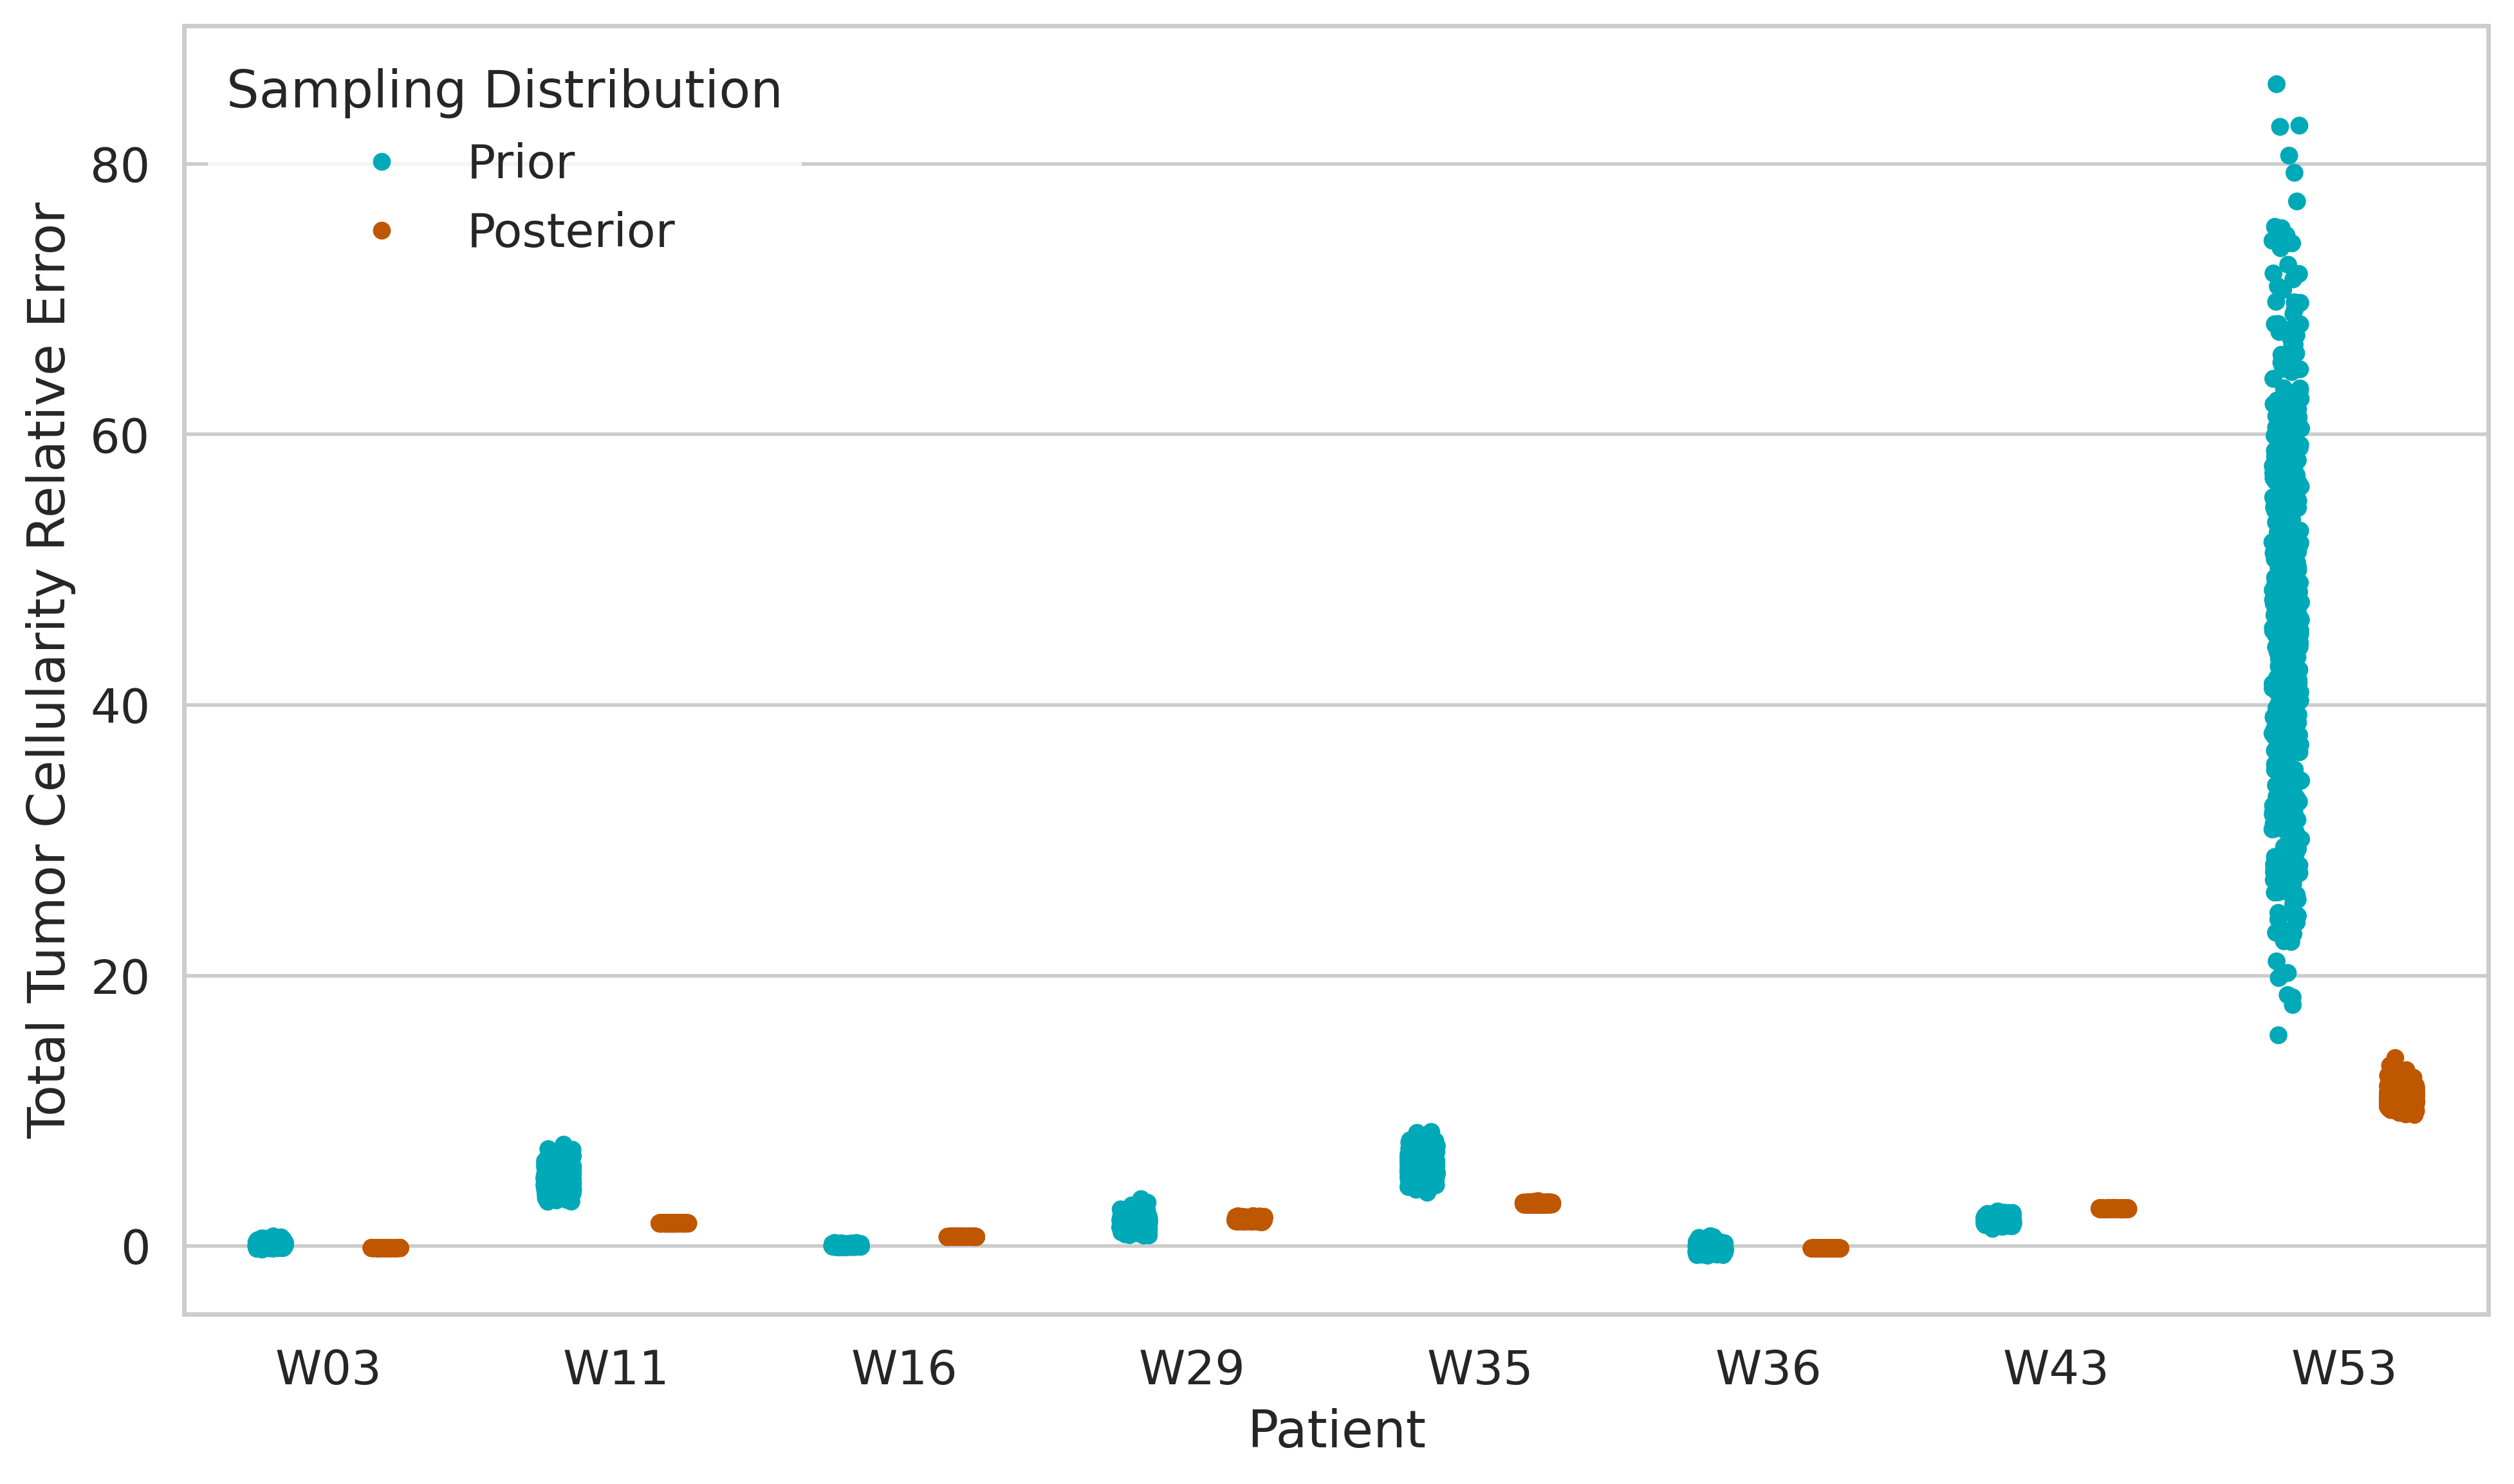

In [22]:
# Filter the data for PWRDTX and last-to-final
l2f_pwrdtx_df = relative_error_df[
    (relative_error_df["experiment_type"] == "pwrdtx") & 
    (relative_error_df["sample_type"] == "last-to-final")
]

# Create the plot
plt.figure(figsize=(10, 6))
sns.stripplot(
    data=l2f_pwrdtx_df,
    x="patient",
    y="value",
    hue="pred_label",
    dodge=True,
    jitter=True,
    palette=[utblue, utorange]
)

# Customize the plot
# plt.title("Relative Error in Total Tumor Cellularity Prediction")
plt.xlabel("Patient")
plt.ylabel("Total Tumor Cellularity Relative Error")
plt.xticks(rotation=0)
plt.legend(title="Sampling Distribution")
plt.tight_layout()

# Show the plot
plt.savefig("ivygap_ttc_l2f.pdf")
plt.show()

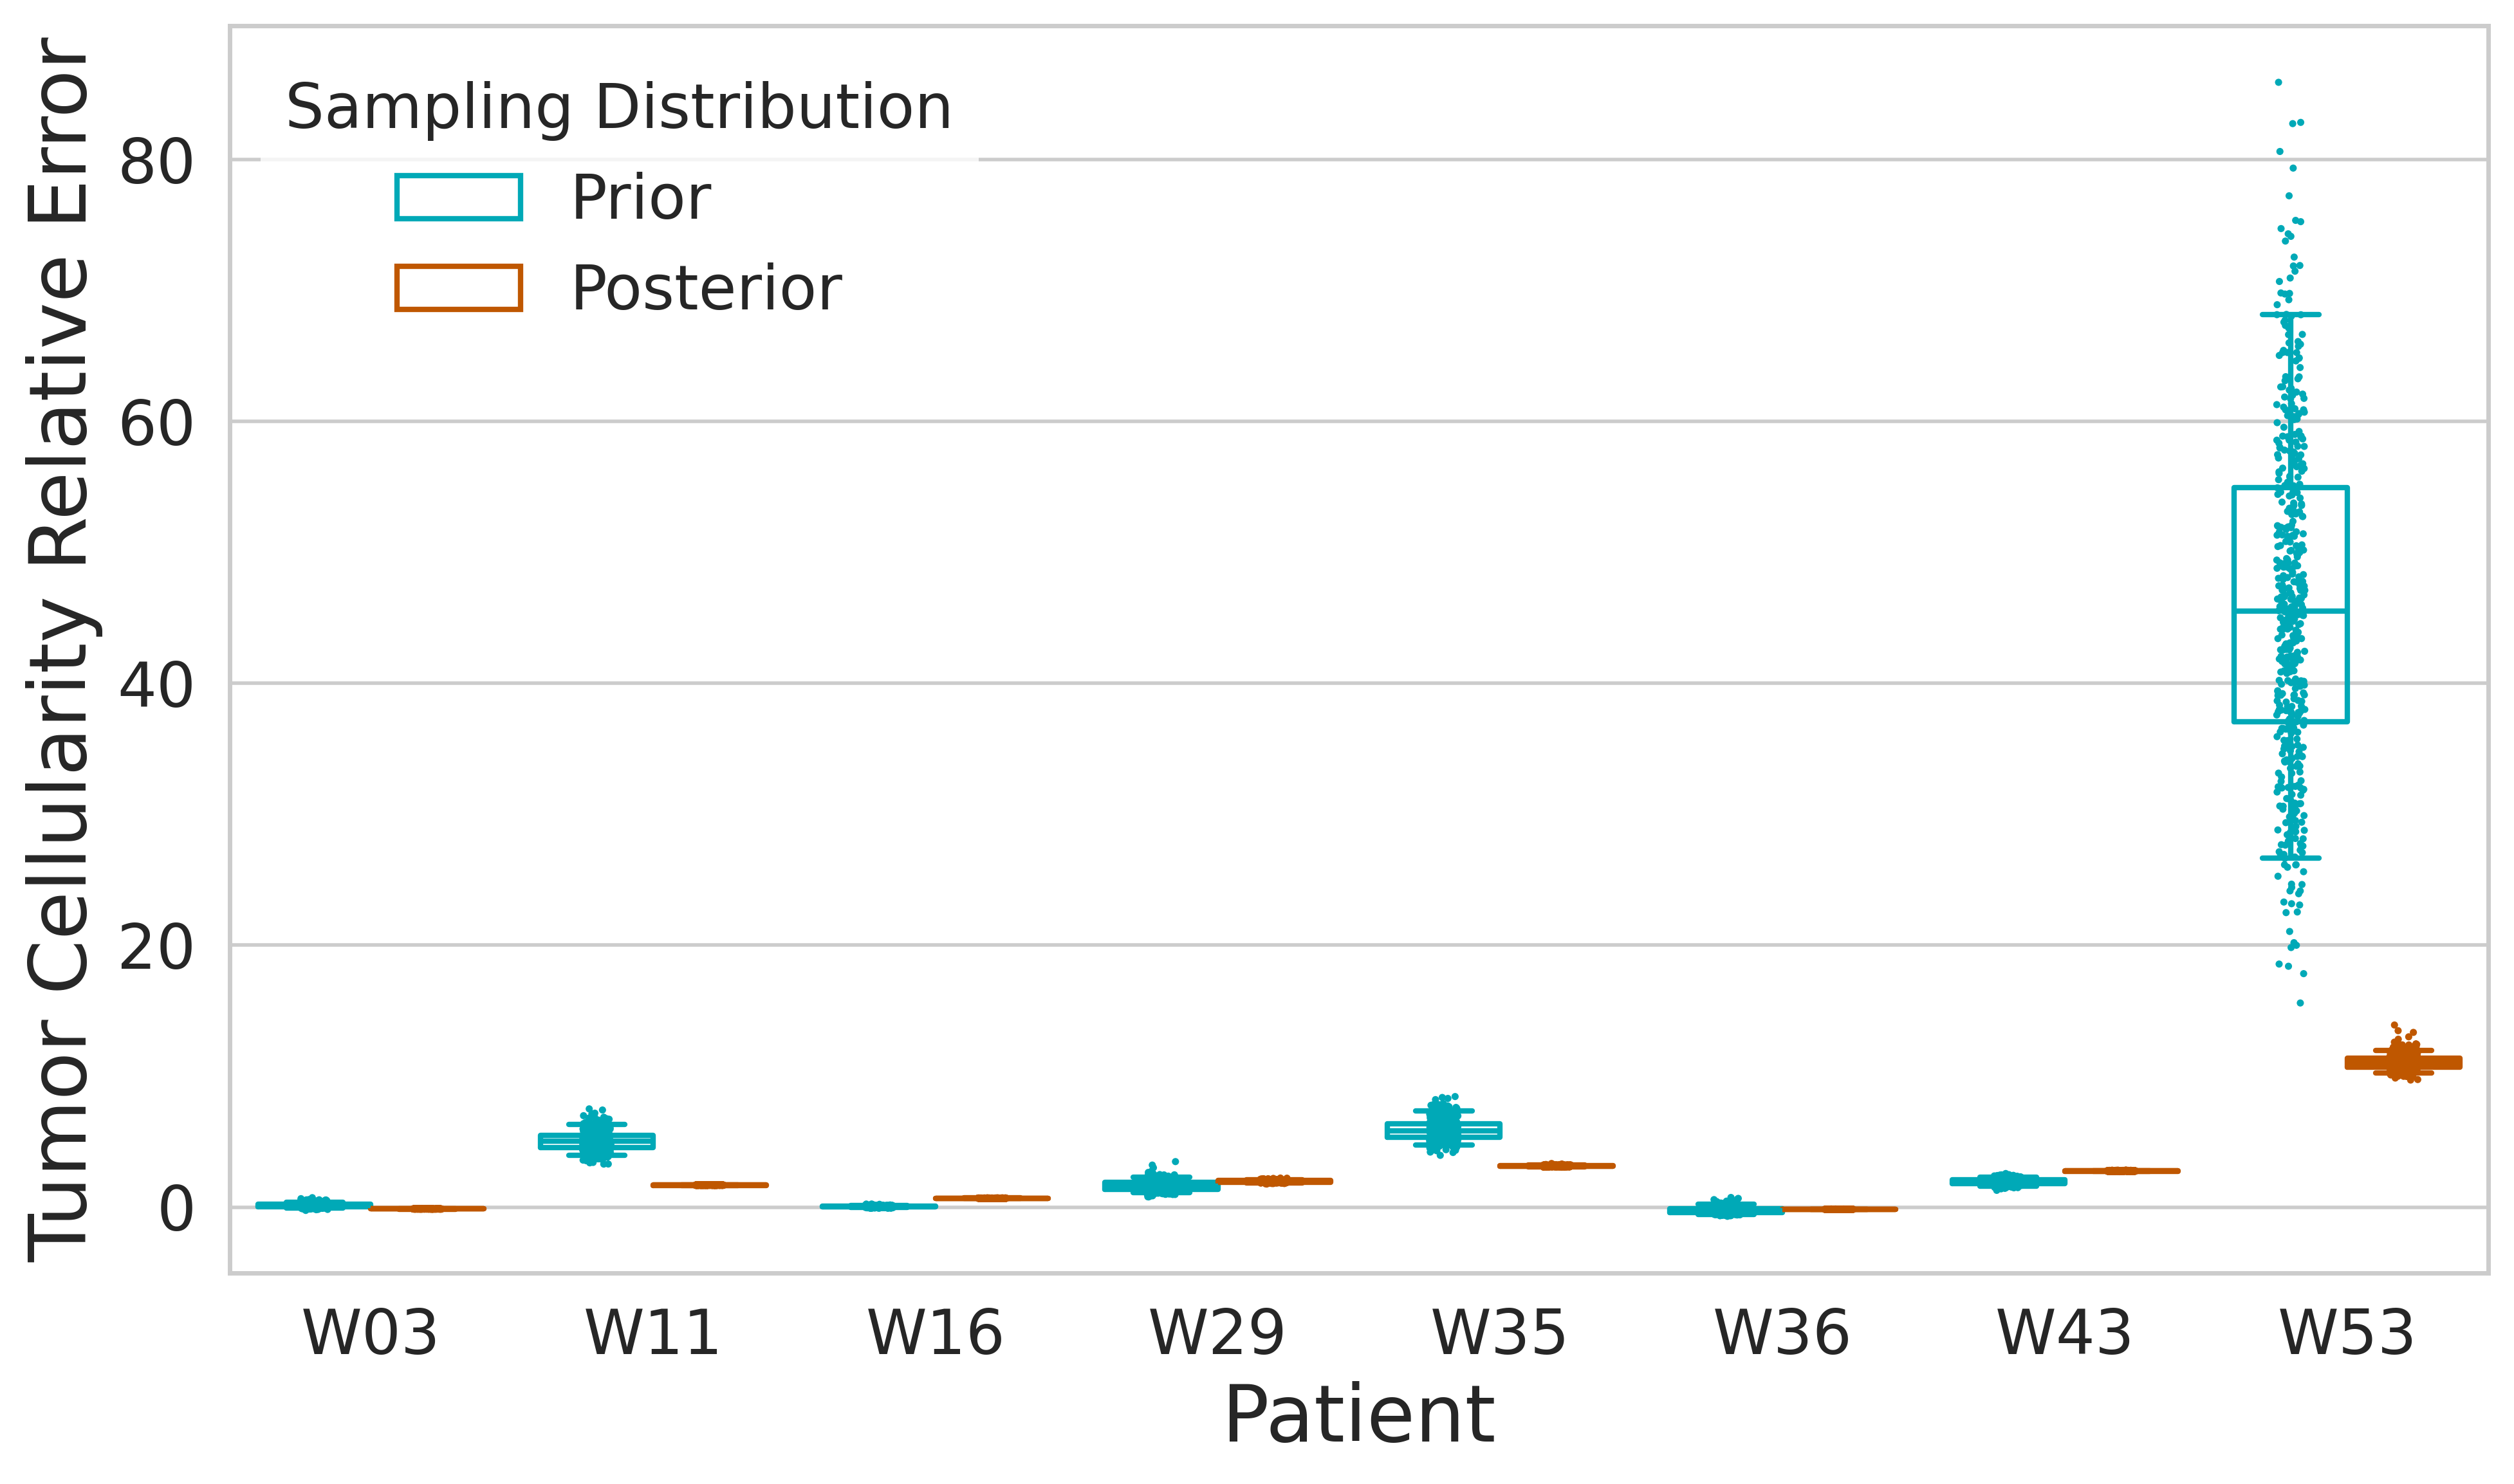

In [23]:
# Filter the data for PWRDTX and last-to-final
l2f_pwrdtx_df = relative_error_df[
    (relative_error_df["experiment_type"] == "pwrdtx") & 
    (relative_error_df["sample_type"] == "last-to-final")
]

# Create the plot
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=l2f_pwrdtx_df,
    x="patient",
    y="value",hue="pred_label",
    fill=False,
    palette=[utblue, utorange],
    showfliers=False,
    whis=[5, 95],
)

ax = sns.stripplot(
    data=l2f_pwrdtx_df,
    x="patient",
    y="value",
    hue="pred_label",
    dodge=True,
    jitter=True,
    palette=[utblue, utorange],
    size=2
)

# Customize the plot
# plt.title("Relative Error in Total Tumor Cellularity Prediction")
plt.xlabel("Patient", fontsize=22)
plt.ylabel("Tumor Cellularity Relative Error", fontsize=22)
plt.xticks(rotation=0, fontsize='large')
plt.yticks(fontsize='large')

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2], title="Sampling Distribution", fontsize='large', title_fontsize='large')
# plt.legend(title="Sampling Distribution")

plt.tight_layout()

# Show the plot
plt.savefig("ivygap_ttc_l2f.pdf")
plt.show()

In [24]:
i2f_prior_stats = []
i2f_la_post_stats = []
lo = 0.05
hi = 0.95
for name in cohort:
    i2f_prior_stats.append(compute_stats(i2f_pwrdtx_df, name, "Prior", lo, hi))

for name in cohort:
    i2f_la_post_stats.append(compute_stats(i2f_pwrdtx_df, name, "Posterior", lo, hi))

Mean W03 (Prior): 2.8633533146475085
Std. Dev. W03 (Prior): 1.49645126445017
Credible Interval (0.05, 0.95) of W03 (Prior): (0.5549664656805042, 5.394197930638937)
Mean W11 (Prior): 20.925299440761776
Std. Dev. W11 (Prior): 0.7636031438465244
Credible Interval (0.05, 0.95) of W11 (Prior): (19.196563289393303, 21.370167484245847)
Mean W16 (Prior): -0.9936136727816564
Std. Dev. W16 (Prior): 0.029087791140647013
Credible Interval (0.05, 0.95) of W16 (Prior): (-1.0, -0.9725851373369024)
Mean W29 (Prior): 2.9657558216357742
Std. Dev. W29 (Prior): 2.773267587626092
Credible Interval (0.05, 0.95) of W29 (Prior): (-0.5251873448834017, 8.284011998746179)
Mean W35 (Prior): 19.37907275581496
Std. Dev. W35 (Prior): 6.114664541295215
Credible Interval (0.05, 0.95) of W35 (Prior): (9.379797974698661, 29.660478006752598)
Mean W36 (Prior): 1.2700567858012328
Std. Dev. W36 (Prior): 1.1977210007140933
Credible Interval (0.05, 0.95) of W36 (Prior): (-0.4301639826708987, 3.5407228854397763)
Mean W43 (Prio

#### Visualize all results across all experiments.

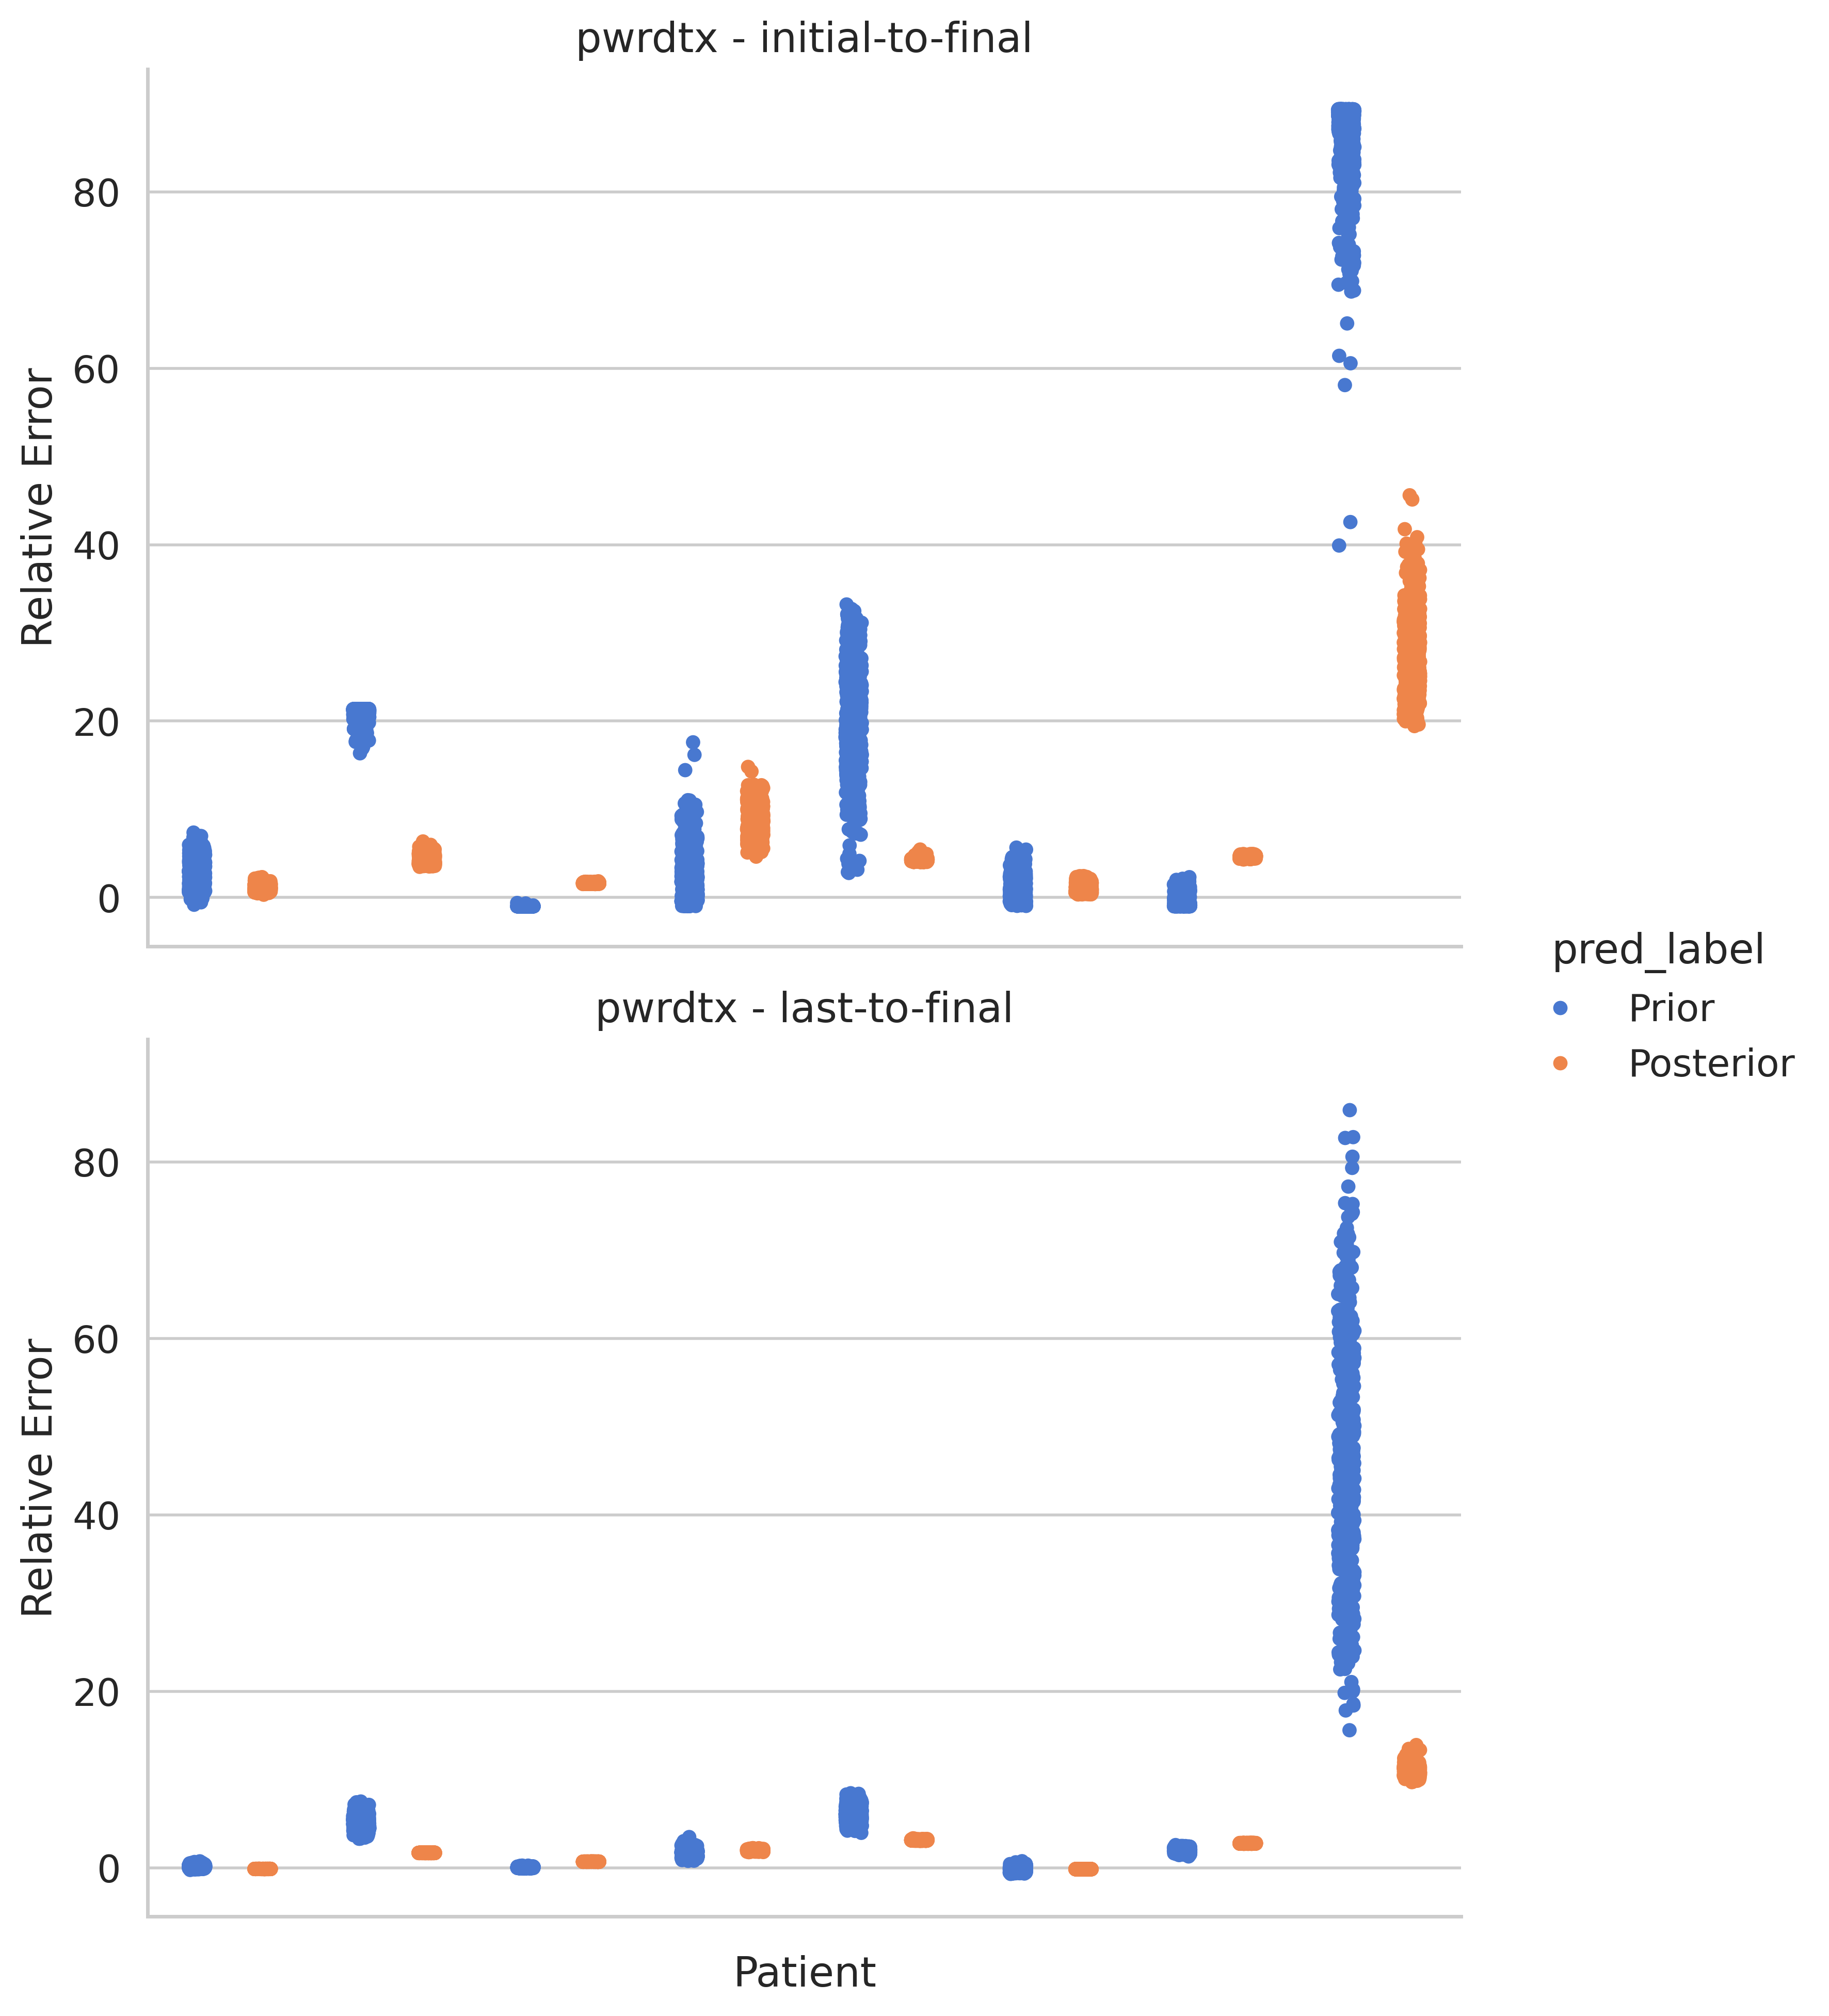

In [25]:
# Create the facet grid for side-by-side plots for prediction types
g = sns.catplot(
    data=relative_error_df,
    x="patient",
    y="value",
    hue="pred_label",
    col="experiment_type",
    row="sample_type",
    kind="strip",
    height=5,
    aspect=1.5,
    dodge=True
)

# Add plot titles and adjust layout
g.set_axis_labels("Patient", "Relative Error")
g.set_titles("{col_name} - {row_name}")
g.set_xticklabels(rotation=90)
g.tight_layout()

# Display the plot
plt.show()
